# Practical Machine Learning for Physicists
## Week 6 Exercise 
## Deadline Monday 30th November at 12pm (Noon)

# Student ID: 19012516

In this notebook you will be trying to predict a system using incomplete information. We will set up the equations of motions for a simple double pendulum (or should that be a double simple pendulum. Then we will see if a machine learning technique can predict the future position of the lower mass, using only the lower mass positions.

### Kinematics of the double pendulum
Let's specify our problem in terms of the following, with the origin at the pivot point of the top pendulum. This is just background for the machine learning tasks at the bottom of the notebook.

#### Positions
$$x_1 = L_1 \sin \theta_1$$
$$y_1 = -L_1 \cos \theta_1$$
$$x_2 = x_1 + L_2 \sin \theta_2$$
$$y_2 = y_1 - L_2 \cos \theta_2$$

#### Velocities
$$\dot{x}_1 = \dot{\theta_1} L_1 \cos \theta_1$$
$$\dot{y_1} =  \dot{\theta_1} L_1 \sin \theta_1$$
$$\dot{x_2} = \dot{x_1} + \dot{\theta_2} L_2 \cos \theta_2$$
$$\dot{y_2} = \dot{y_1} + \dot{\theta_2} L_2 \sin \theta_2$$


#### Accelerations

$$\ddot{x}_1 = -\dot{\theta_1}^2 L_1 \sin \theta_1 + \ddot{\theta_1} L_1 \cos \theta_1$$
$$\ddot{y_1} =  \dot{\theta_1}^2 L_1 \cos \theta_1 + \ddot{\theta_1} L_1 \sin \theta_1$$
$$\ddot{x_2} = \ddot{x_1} - \dot{\theta_2}^2 L_2 \sin \theta_2 + \ddot{\theta_2} L_2 \cos \theta_2$$
$$\ddot{y_2} = \ddot{y_1} + \dot{\theta_2}^2 L_2 \cos \theta_2 + \ddot{\theta_2} L_2 \sin \theta_2$$

#### Energies
Let $v_1^2 = \dot{x_1}^2 +\dot{y_1}^2$ and $v_2^2 = \dot{x_2}^2 +\dot{y_2}^2$ then the kinetic energies $T_1$ and $T_2$ are
$$ T_1 = \frac{1}{2}m_1 v_1^2 = \frac{1}{2}m_1 L_1^2 \dot{\theta_1}^2 $$
$$ T_2 = \frac{1}{2}m_2 v_2^2 = \frac{1}{2}m_2 \left( L_1^2 \dot{\theta_1}^2 + L_2^2 \dot{\theta_2}^2 + 2L_1 L_2 \cos(\theta_1-\theta_2) \dot{\theta_1} \dot{\theta_2} \right) $$

The potential enrgies are
$$V_1 = m_1 g y_1 = - m_1 g L_1 \cos \theta_1$$
$$V_2 = m_2 g y_2 = -m_2 g ( L_1 \cos \theta_1 + L_2 \cos \theta_2)$$

#### Langrangian
Now we form the Lagrangian $L=T-V=T_1+T_2 -V_1 -V_2$ and use the Euler-Lagrange equations:
$$\frac{\partial L}{\partial \theta_1} = \frac{d}{dt}\frac{\partial L}{\partial \dot{\theta_1}}$$
$$\frac{\partial L}{\partial \theta_2} = \frac{d}{dt}\frac{\partial L}{\partial \dot{\theta_2}}$$

Applying these gives
$$-(m_1+m_2) g L_1 \sin \theta_1 = (m_1+m_2) L_1^2 \ddot{\theta_1} + m_2 L_1 L_2 \sin(\theta_1-\theta_2) \dot{\theta_2}^2 +  m_2 L_1 L_2 \cos(\theta_1-\theta_2) \ddot{\theta_2} $$
and
$$ -m_2 g L_2 \sin \theta_2 = m_2 L_2 \ddot{\theta_2} + m_2 L_1 L_2 \cos(\theta_1-\theta_2) \ddot{\theta_1} + m_2 L_1 L_2 \sin(\theta_1-\theta_2) \dot{\theta_1}^2 $$ 


#### Equations of motions
$$ \omega_1 = \dot{\theta_1}$$  

$$ \omega_2 = \dot{\theta_2}$$ 
$$ \ddot\theta_1 = \frac{1}{L_1\xi}\left[L_1m_2\cos(\theta_1-\theta_2)\sin(\theta_1-\theta_2)\omega_1^2 + L_2m_2\sin(\theta_1-\theta_2)\omega_2^2 - m_2g\cos(\theta_1-\theta_2)\sin(\theta_2) + (m_1+m_2)g\sin(\theta_1) \right] $$
$$ \ddot\theta_2 = \frac{1}{L_2\xi}\left[L_2m_2\cos(\theta_1-\theta_2)\sin(\theta_1-\theta_2)\omega_2^2 + L_1(m_1+m_2)\sin(\theta_1-\theta_2)\omega_1^2+(m_1+m_2)g\sin(\theta_1)\cos(\theta_1-\theta_2) - (m_1+m_2)g\sin(\theta_2) \right] $$
where 
$$\xi \equiv \cos^2(\theta_1-\theta_2)m_2-m_1-m_2$$


In [5]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy.integrate import solve_ivp
from tqdm import tqdm

import matplotlib.style #Some style nonsense
import matplotlib as mpl #Some more style nonsense

#Set default figure size
#mpl.rcParams['figure.figsize'] = [12.0, 8.0] #Inches... of course it is inches
mpl.rcParams["legend.frameon"] = False
mpl.rcParams['figure.dpi']=200 # dots per inch



In [2]:
def rhs(t, z, L1, L2, m1, m2, g):
    """
    Returns the right-hand side of the ordinary differential equation describing the double pendulem
    """
    theta1, w1, theta2, w2 = z    #The four components
    cos12 = np.cos(theta1 - theta2)
    sin12 = np.sin(theta1 - theta2)
    sin1 = np.sin(theta1)
    sin2 = np.sin(theta2)
    xi = cos12**2*m2 - m1 - m2
    w1dot = ( L1*m2*cos12*sin12*w1**2 + L2*m2*sin12*w2**2
            - m2*g*cos12*sin2      + (m1 + m2)*g*sin1)/(L1*xi)
    w2dot = -( L2*m2*cos12*sin12*w2**2 + L1*(m1 + m2)*sin12*w1**2
            + (m1 + m2)*g*sin1*cos12  - (m1 + m2)*g*sin2 )/(L2*xi)
    return w1, w1dot, w2, w2dot   #Return the w's and the wdot's


def to_cartesian(theta1, w1, theta2, w2, L1, L2):
    """ Transforms theta and omega to cartesian coordinates
    and velocities x1, y1, x2, y2, vx1, vy1, vx2, vy2
    """
    x1 = L1 * np.sin(theta1)
    y1 = -L1 * np.cos(theta1)
    x2 = x1 + L2 * np.sin(theta2)
    y2 = y1 - L2 * np.cos(theta2)
    vx1 = L1*np.cos(theta1)*w1
    vy1 = L1*np.sin(theta1)*w1
    vx2 = vx1 + L2*np.cos(theta2)*w2
    vy2 = vy1 + L2*np.sin(theta2)*w2
    return x1, y1, x2, y2, vx1, vy1, vx2, vy2
    

In [3]:
# Set up the initial conditions. Here we have lengths and masses
L1, L2 = 1., 1.
m1, m2 = 3., 1.
g = 9.81     # [m/s^2]. Gravitational acceleration

#Starting angles
z0=[np.pi/4,0,np.pi/4,0]
#z0=[0.1,0,0.1,0]

#Time ranges
tmax, dt = 50, 0.1
t = np.arange(0, tmax+dt, dt)

In [4]:
# Solve initial value problem
ret = solve_ivp(rhs, (0,tmax), z0, t_eval=t, args=(L1, L2, m1, m2, g))
z=ret.y
print(np.shape(z))

# Extract result
theta1, w1, theta2, w2 = z[0], z[1], z[2], z[3]
x1, y1, x2, y2, vx1, vy1, vx2, vy2 = to_cartesian(theta1, w1, theta2, w2, L1, L2)

(4, 501)


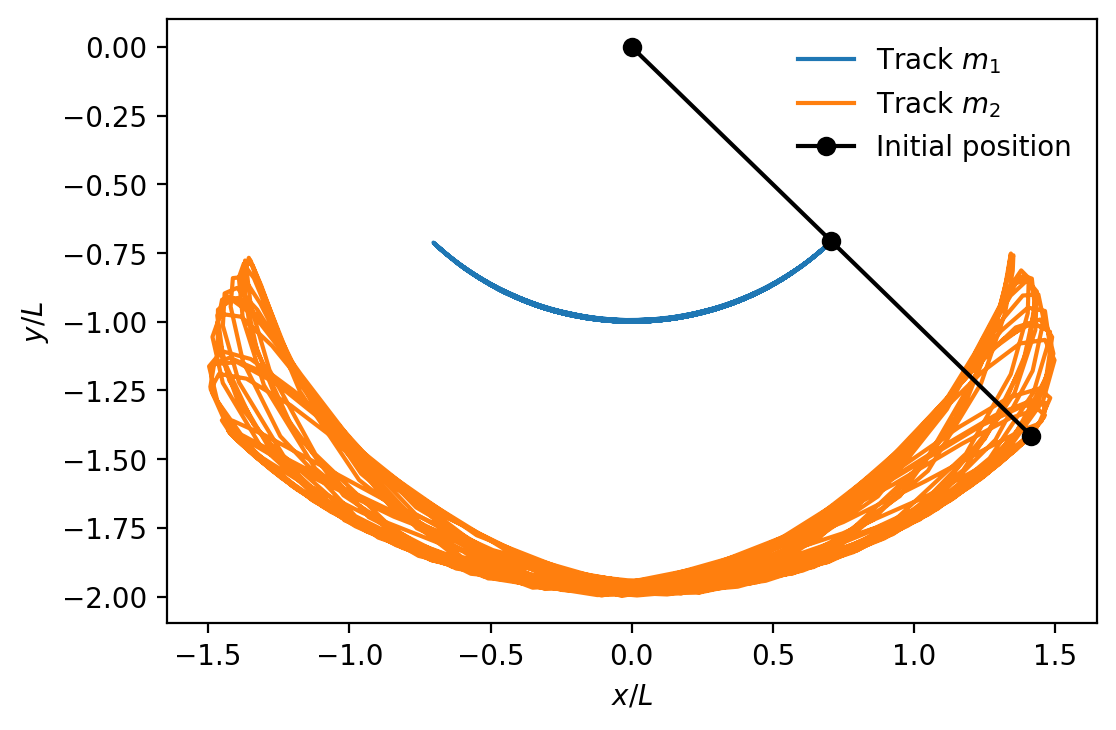

In [6]:
fig,ax=plt.subplots()
ax.plot(x1, y1, label=r"Track $m_1$")
ax.plot(x2, y2, label=r"Track $m_2$")
ax.plot([0, x1[0], x2[0]], [0, y1[0], y2[0]], "-o", label="Initial position", c='k')
plt.ylabel(r"$y/L$")
plt.xlabel(r"$x/L$")
ax.legend()

# Exercises: Predicting Chaos
1. Design and train a recurrent neural network (of your choice) to predict the future positions, where future is defined as $t=t_0 + 20 \delta t$, of the masses $m_1$ and $m_2$ using their cartesian coordinates and the initial conditions  $z_0=[\pi/4,0,\pi/4,0]$. 
2. How stable is your network to variations in initial conditions? Make a plot of $x$ and $y$ vs time to show the network prediction in comparison to the solution from solve_ivp
3. How far into the future can a network predict? Make a plot showing how the deviation between predicted position and actual position (from solve_ivp above) vary as a function of extrapolation time from $t=t_0 + 20 \delta t$ to $t=t_0 + 100 \delta t$  (e.g. for each extrapolation time, train a new version of the network and then plot the performance)
4. Repeat steps 1-3 for the initial conditions $z_0=[\pi/2,0,\pi/2,0]$ which give a much more complex path.
5. Repeat steps 1-4 but only train your neural network on the cartesian coordinates of the mass $m_2$ (i.e without showing your neural network the positions of the mass $m_1$)



# Task 1. 
Design and train a recurrent neural network (of your choice) to predict the future positions, where future is defined as $t=t_0 + 20 \delta t$, of the masses $m_1$ and $m_2$ using their cartesian coordinates and the initial conditions  $z_0=[\pi/4,0,\pi/4,0]$. 

# Shape inputs into LSTM layers
The following website was helpful in understanding the shape of array needed to be added to LSTM layers. 
<p>https://machinelearningmastery.com/reshape-input-data-long-short-term-memory-networks-keras/
<p>LSTM layer must be three-dimensional and the dimensions are:
<p>Samples:  One sequence is one sample. A batch is comprised of one or more samples.
<p>Time Steps. One time step is one point of observation in the sample.
<p>Features. One feature is one observation at a time step.



## Position Array
Position state of system described by $x_1, y_1, x_2, y_2$. There are numpy arrays for all of these x1, y1, x2, y2. Each is 501 long corresponding to times from 0 to 50 in steps of 0.1 (variable: dt), contained in numpy array t. First  use np.stack to form an array containing these 4 values for all different points in time: (501, 4) array.

## Training Input
Offset is given as 20dt. The overall plan is to train onto a target (x1,y1,x2,y2) using the previous 20 values of (x1,y1,x2,y2). To do this we need a training input set with 481 batches of 20 sequencial samples of (x1,y1,x2,y2). First sample will run from $t=t_0$ to $t=t_0+ 20 \delta t$. Array shape: (481,20,4)

## Training Target 
The training target set is 481 batches of 1 value of (x1,y1,x2,y2). The first training batch should train on the 21st value of (x1,y1,x2,y2)- NB arrays run from index 0, so this would be index value 20. The shape of the training target array should be: (481,4) which can be expanded to (481,1,4) for training.

## LSTM model
A fairly simple LSTM model was used and adapted from Week6_Prediction.ipynb. It contained one LSTM layer with 20 neurons and one dense layer with 4 neurons to match x1,y1,x2,y2.

In [7]:
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm

# from https://numpy.org/doc/stable/reference/generated/numpy.stack.html#numpy.stack
pos = np.stack((x1,y1,x2,y2), axis=-1)#501 length array of x1, y1, x2, y2 values

#adapted from Week6_Prediction.ipynb
windowsize=20 #Number of samples we will use to train our network

#adapted from Week6_Prediction.ipynb
def shapeArray(x,windowsize):
    Input= np.array([x[i : i + windowsize] for i in range(len(x)-(windowsize))])
    Target= np.array([x[i+windowsize] for i in range(len(x)-(windowsize))])
    return (Input,Target)


#adapted from Week6_Prediction.ipynb
Input, Target = shapeArray(pos,windowsize)

print('Input shape',Input.shape)
print('Target shape',Target.shape)

print(Input[20,0])#check to demonstrate the offset
print(Target[0])

#adapted from Week6_Prediction.ipynb
model=keras.models.Sequential()
model.add(keras.layers.LSTM(20,input_shape=(20, 4), return_sequences=False))#(20,4) represents the 20 wide window and 4 features
model.add(keras.layers.Dense(4,activation="linear"))# need 4 neurons to return the model values for x1, y1, x2, y2.
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

Input shape (481, 20, 4)
Target shape (481, 4)
[ 0.03454826 -0.99940303  0.32885642 -1.95511361]
[ 0.03454826 -0.99940303  0.32885642 -1.95511361]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20)                2000      
                                                                 
 dense (Dense)               (None, 4)                 84        
                                                                 
Total params: 2,084
Trainable params: 2,084
Non-trainable params: 0
_________________________________________________________________


# Task 1
## Training
Training could now be performed by looping through the 481 batches. For each iteration, the training input shape was thus (1,20,4) and target shape (1,1,4)
<p>It was decided to take the mean of the last 50 values of cost as an overall measure of the success of the training. There was some volatility in the cost function and this would avoid any low or high end results.

100%|██████████| 481/481 [00:06<00:00, 71.17it/s] 


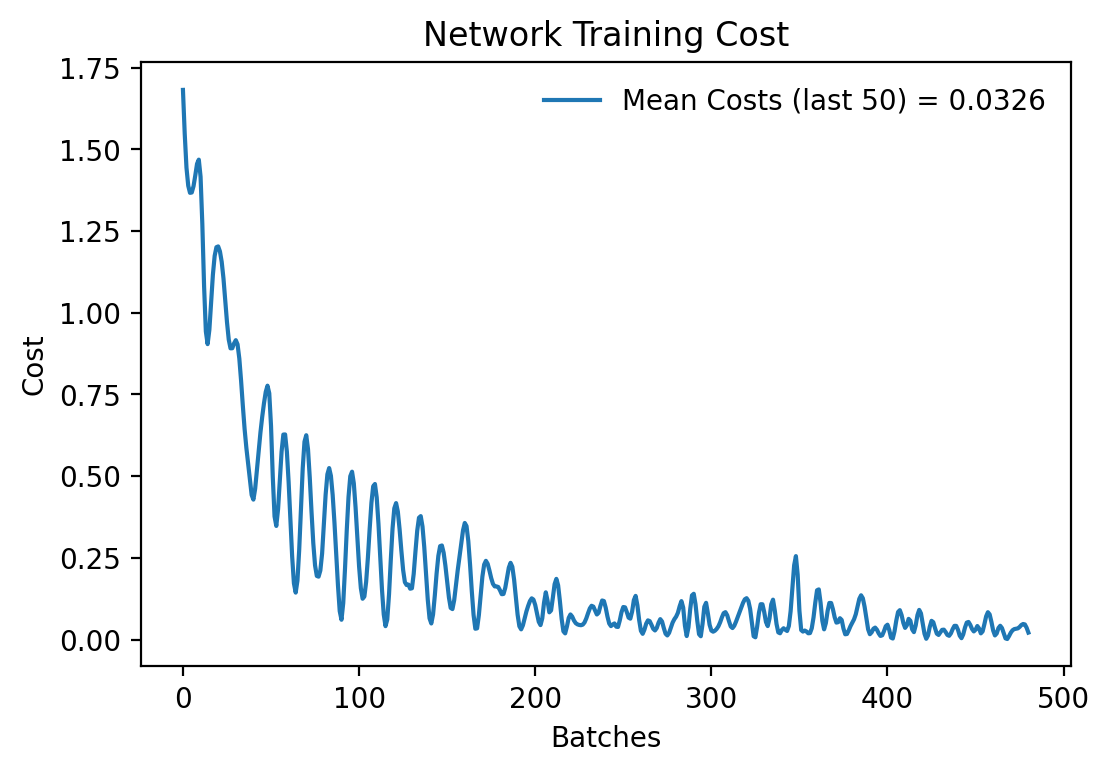

In [8]:
#adapted from Week6_Prediction.ipynb
batches=len(Input)#Number of batches
costs=np.zeros(batches)  #Array for plotting cost
for i in tqdm(range(batches)):
    In = Input[i].reshape(1,20, 4)
    Tar = Target[i].reshape(1,1, 4)
    costs[i]=model.train_on_batch(In, Tar) #Train the network

#Plot costs vs batches
fig,ax=plt.subplots()
ax.plot(np.arange(batches),costs,label=f"Mean Costs (last 50) = {np.mean(costs[-50:]):0.4f}")
ax.set_xlabel("Batches")
ax.set_ylabel("Cost")
ax.set_title("Network Training Cost")
ax.legend();

# Task 1
Completed. The training reduces the cost function from above 1.0 to around 0.03. 

# Task 2. 
How stable is your network to variations in initial conditions? Make a plot of $x$ and $y$ vs time to show the network prediction in comparison to the solution from solve_ivp

Dealing with the second part of Task 2 first, below are plots of x1,y1,x2,y2 versus time for solve_ivp (blue) and model predicted (orange). 

(481, 4)
[-0.29626822 -0.91044712 -1.09754598 -1.56008911]
[-0.29626822 -0.9104471  -1.097546   -1.5600891 ]


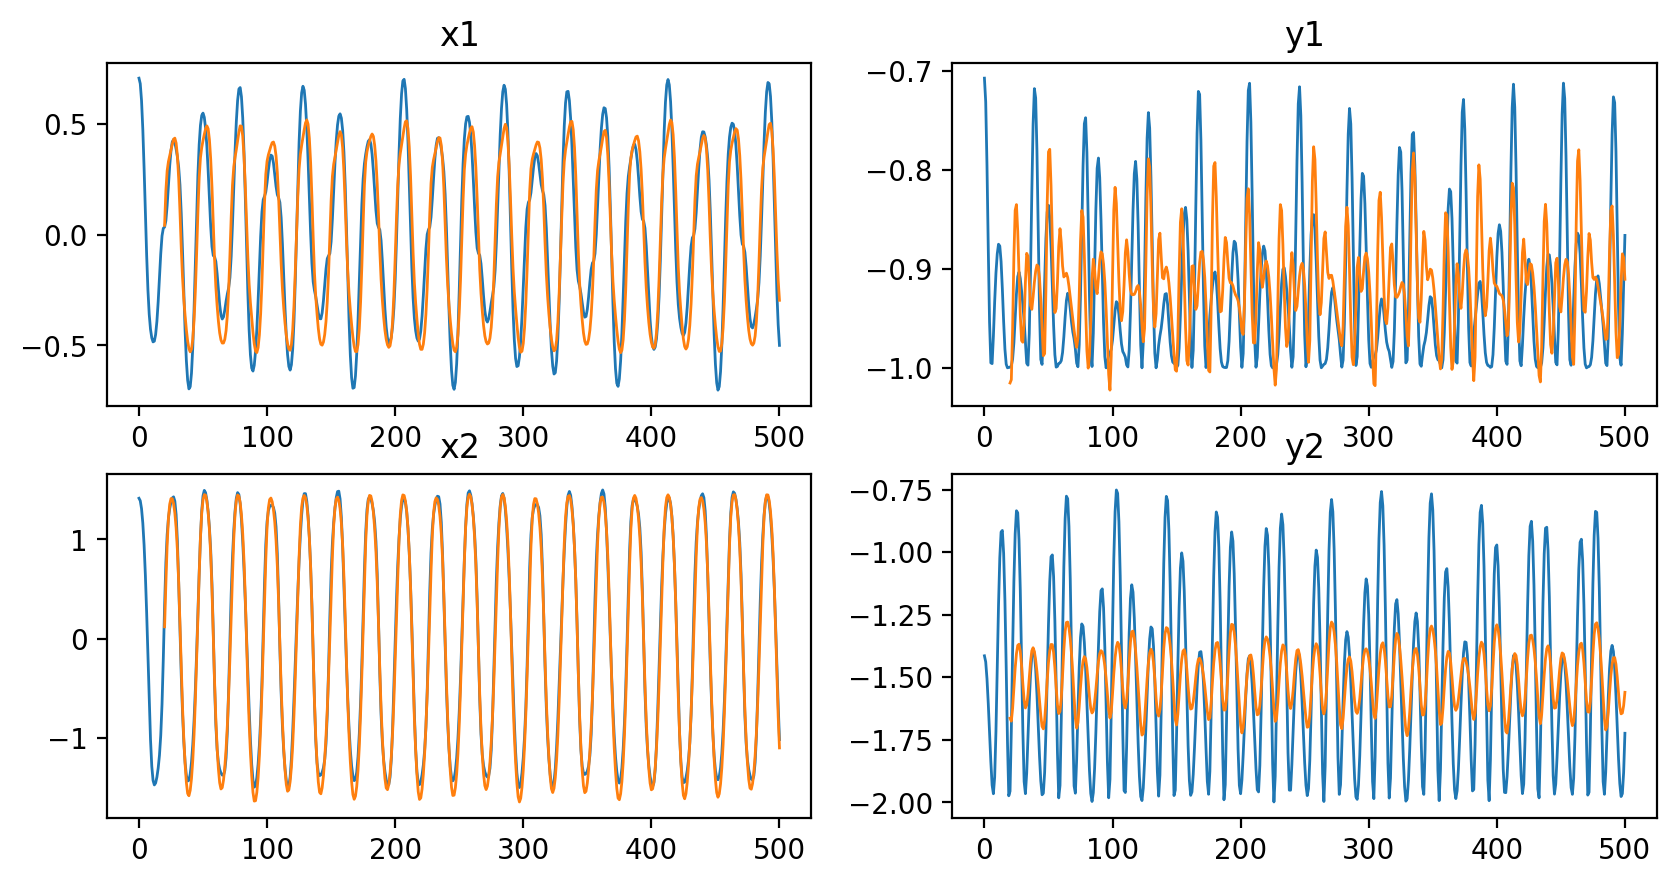

In [9]:
pred=np.zeros(len(Input)*4).reshape(len(Input),4)# array to collect model predictions
for i in range(len(Input)):
  y_in = Input[i].reshape(1,20,4)
  y_out = model.predict_on_batch(y_in)
  pred[i] = y_out

print(pred.shape)#check it has worked
print(pred[-1])
print(y_out[0])

t = np.arange(501)#all t values
t_p = np.arange(481) +20 #t values from t=20, i.e. for predicted values

fig,ax = plt.subplots(ncols=2,nrows=2,figsize=(10,5))
ax[0,0].plot(t, pos[:,0], linewidth = 1)#from solv_ivp
ax[0,0].plot(t_p,pred[:,0], linewidth = 1)#from our model
ax[0,0].set_title('x1')

ax[0,1].plot(t, pos[:,1], linewidth = 1)
ax[0,1].plot(t_p,pred[:,1], linewidth = 1)
ax[0,1].set_title('y1')

ax[1,0].plot(t, pos[:,2], linewidth = 1)
ax[1,0].plot(t_p,pred[:,2], linewidth =1)
ax[1,0].set_title('x2')


ax[1,1].plot(t, pos[:,3], linewidth = 1)
ax[1,1].plot(t_p,pred[:,3], linewidth =1)
ax[1,1].set_title('y2');

# Task 2
Looking at the above graphs, the methodology looks like it has worked in that the orange lines (model) start when t=20, while the solve_ivp start from t=0.

The model seems accurate in capturing the turning points in the motion, however the amplitudes of motion can be very different, e.g. y1, y2 and to a lesser extent x1. The model fits very closely for x2, which is perhaps not surprising as the solv_inv plot is the most regular. 

## Stability to initial conditons
Now answering the first part of Task 2, the model was re-run with different initial conditions. First, using smaller starting angles of $\pi / 8$.

In [10]:
# Set up the initial conditions. Here we have lengths and masses
L1, L2 = 1., 1.
m1, m2 = 3., 1.
g = 9.81     # [m/s^2]. Gravitational acceleration

#Starting angles
z0=[np.pi/8,0,np.pi/8,0]# change starting angles
#z0=[0.1,0,0.1,0]

#Time ranges
tmax, dt = 50, 0.1
t = np.arange(0, tmax+dt, dt)

# Solve initial value problem
ret = solve_ivp(rhs, (0,tmax), z0, t_eval=t, args=(L1, L2, m1, m2, g))
z=ret.y
print(np.shape(z))

# Extract result
theta1, w1, theta2, w2 = z[0], z[1], z[2], z[3]
x1, y1, x2, y2, vx1, vy1, vx2, vy2 = to_cartesian(theta1, w1, theta2, w2, L1, L2)


(4, 501)


In [11]:
# from https://numpy.org/doc/stable/reference/generated/numpy.stack.html#numpy.stack
pos = np.stack((x1,y1,x2,y2), axis=-1)#501 length array of x1, y1, x2, y2 values

#adapted from Week6_Prediction.ipynb
windowsize=20 #Number of samples we will use to train our network

#adapted from Week6_Prediction.ipynb
def shapeArray(x,windowsize):
    Input= np.array([x[i : i + windowsize] for i in range(len(x)-(windowsize))])
    Target= np.array([x[i+windowsize] for i in range(len(x)-(windowsize))])
    return (Input,Target)


#adapted from Week6_Prediction.ipynb
Input, Target = shapeArray(pos,windowsize)

print('Input shape',Input.shape)
print('Target shape',Target.shape)

print(Input[20,0])#check to demonstrate the offset
print(Target[0])

#adapted from Week6_Prediction.ipynb
model=keras.models.Sequential()
model.add(keras.layers.LSTM(20,input_shape=(20, 4), return_sequences=False))#(20,4) represents the 20 wide window and 4 features
model.add(keras.layers.Dense(4,activation="linear"))# need 4 neurons to return the model values for x1, y1, x2, y2.
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

Input shape (481, 20, 4)
Target shape (481, 4)
[ 0.02206752 -0.99975648  0.3658935  -1.93878987]
[ 0.02206752 -0.99975648  0.3658935  -1.93878987]
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 20)                2000      
                                                                 
 dense_1 (Dense)             (None, 4)                 84        
                                                                 
Total params: 2,084
Trainable params: 2,084
Non-trainable params: 0
_________________________________________________________________


100%|██████████| 481/481 [00:06<00:00, 78.98it/s] 


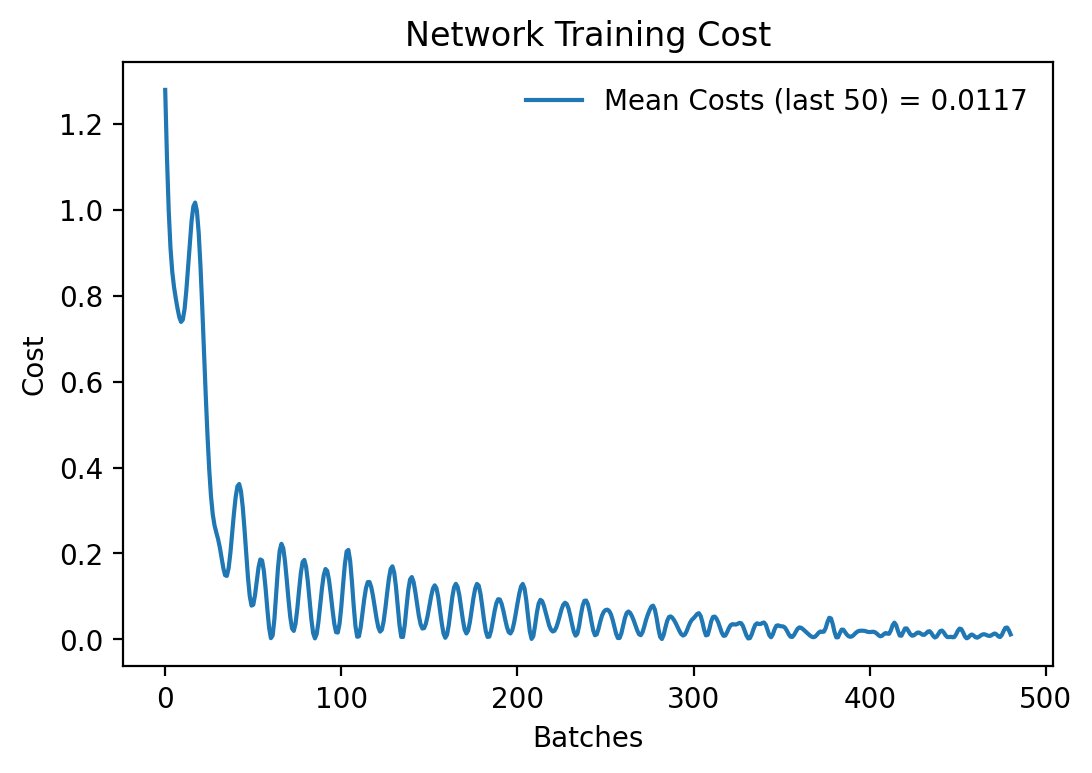

In [12]:
#adapted from Week6_Prediction.ipynb
batches=len(Input)#Number of batches
costs=np.zeros(batches)  #Array for plotting cost
for i in tqdm(range(batches)):
    In = Input[i].reshape(1,20, 4)
    Tar = Target[i].reshape(1,1, 4)
    costs[i]=model.train_on_batch(In, Tar) #Train the network

#Plot costs vs batches
fig,ax=plt.subplots()
ax.plot(np.arange(batches),costs,label=f"Mean Costs (last 50) = {np.mean(costs[-50:]):0.4f}")
ax.set_xlabel("Batches")
ax.set_ylabel("Cost")
ax.set_title("Network Training Cost")
ax.legend();

# Task 2
Using a smaller angle has produced a lower cost function on training. This is expected as a smaller angle will create less complex motion which should be easier to predict. Now, the x1,y1,x2,y2 plots versus t were made

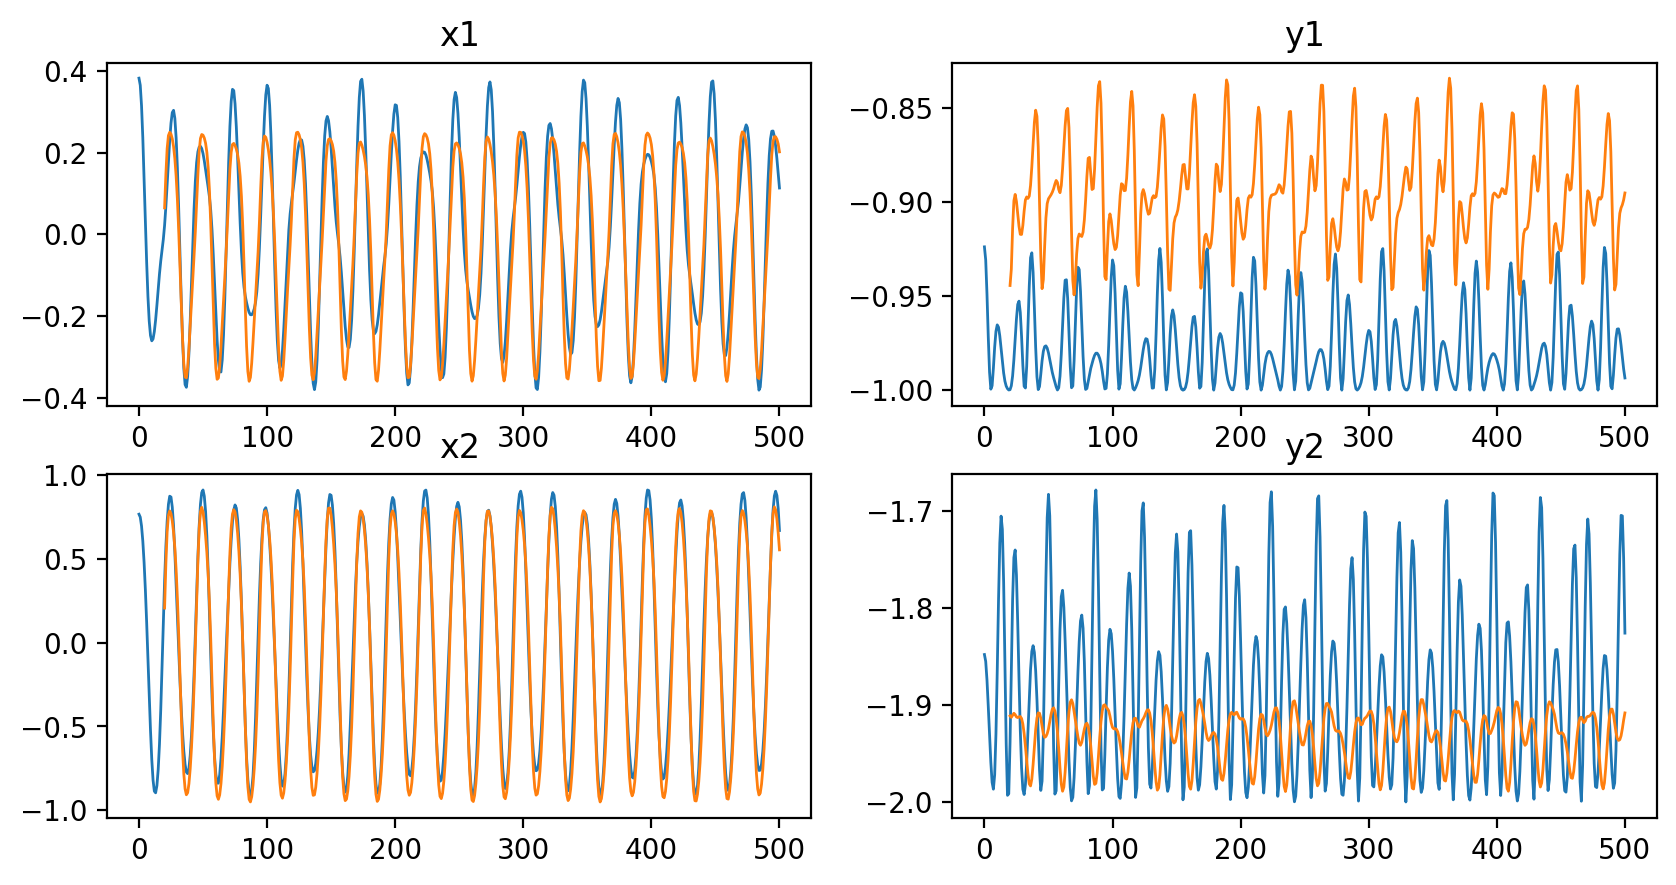

In [13]:
pred=np.zeros(len(Input)*4).reshape(len(Input),4)# array to collect model predictions
for i in range(len(Input)):
  y_in = Input[i].reshape(1,20, 4)
  y_out = model.predict_on_batch(y_in)
  pred[i] = y_out

t = np.arange(501)#all t values
t_p = np.arange(481) +20 #t values from t=20, i.e. for predicted values

fig,ax = plt.subplots(ncols=2,nrows=2,figsize=(10,5))
ax[0,0].plot(t, pos[:,0], linewidth = 1)#from solv_ivp
ax[0,0].plot(t_p,pred[:,0], linewidth = 1)#from our model
ax[0,0].set_title('x1')

ax[0,1].plot(t, pos[:,1], linewidth = 1)
ax[0,1].plot(t_p,pred[:,1], linewidth = 1)
ax[0,1].set_title('y1')

ax[1,0].plot(t, pos[:,2], linewidth = 1)
ax[1,0].plot(t_p,pred[:,2], linewidth =1)
ax[1,0].set_title('x2')


ax[1,1].plot(t, pos[:,3], linewidth = 1)
ax[1,1].plot(t_p,pred[:,3], linewidth =1)
ax[1,1].set_title('y2');

# Task 2
At a lower starting angle, it might be expected that the double pendulum would have a more stable motion and be easier to predict. It is not surprising therefore to obtain a better cost function in training. Looking at the above graphs, however, it looks like there are significant divergences seen in y1 and y2. In particular y2's peaks and troughs are not occurring in the same places for solv_1v and the model. One should note however that the vertical range in the above graphs is much reduced for y1, y2. The divergences in position may not be as large as they appear when you factor in the scaling.

Now a larger angle was tried: not $\pi/2$ as this makes up Task 4, but $\pi/3$

In [14]:
# Set up the initial conditions. Here we have lengths and masses
L1, L2 = 1., 1.
m1, m2 = 3., 1.
g = 9.81     # [m/s^2]. Gravitational acceleration

#Starting angles
z0=[np.pi/3,0,np.pi/3,0]# change starting angles
#z0=[0.1,0,0.1,0]

#Time ranges
tmax, dt = 50, 0.1
t = np.arange(0, tmax+dt, dt)

# Solve initial value problem
ret = solve_ivp(rhs, (0,tmax), z0, t_eval=t, args=(L1, L2, m1, m2, g))
z=ret.y
print(np.shape(z))

# Extract result
theta1, w1, theta2, w2 = z[0], z[1], z[2], z[3]
x1, y1, x2, y2, vx1, vy1, vx2, vy2 = to_cartesian(theta1, w1, theta2, w2, L1, L2)


(4, 501)


In [15]:
# from https://numpy.org/doc/stable/reference/generated/numpy.stack.html#numpy.stack
pos = np.stack((x1,y1,x2,y2), axis=-1)#501 length array of x1, y1, x2, y2 values

#adapted from Week6_Prediction.ipynb
windowsize=20 #Number of samples we will use to train our network

#adapted from Week6_Prediction.ipynb
def shapeArray(x,windowsize):
    Input= np.array([x[i : i + windowsize] for i in range(len(x)-(windowsize))])
    #Target= np.array([x[i +windowsize] for i in range(len(x)-(windowsize)])
    Target= np.array([x[i+windowsize] for i in range(len(x)-(windowsize))])
    return (Input,Target)


#adapted from Week6_Prediction.ipynb
Input, Target = shapeArray(pos,windowsize)

#adapted from Week6_Prediction.ipynb
model=keras.models.Sequential()
model.add(keras.layers.LSTM(20,input_shape=(20, 4), return_sequences=False))#(20,4) represents the 20 wide window and 4 features
model.add(keras.layers.Dense(4,activation="linear"))# need 4 neurons to return the model values for x1, y1, x2, y2.
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 20)                2000      
                                                                 
 dense_2 (Dense)             (None, 4)                 84        
                                                                 
Total params: 2,084
Trainable params: 2,084
Non-trainable params: 0
_________________________________________________________________


100%|██████████| 481/481 [00:06<00:00, 78.84it/s] 


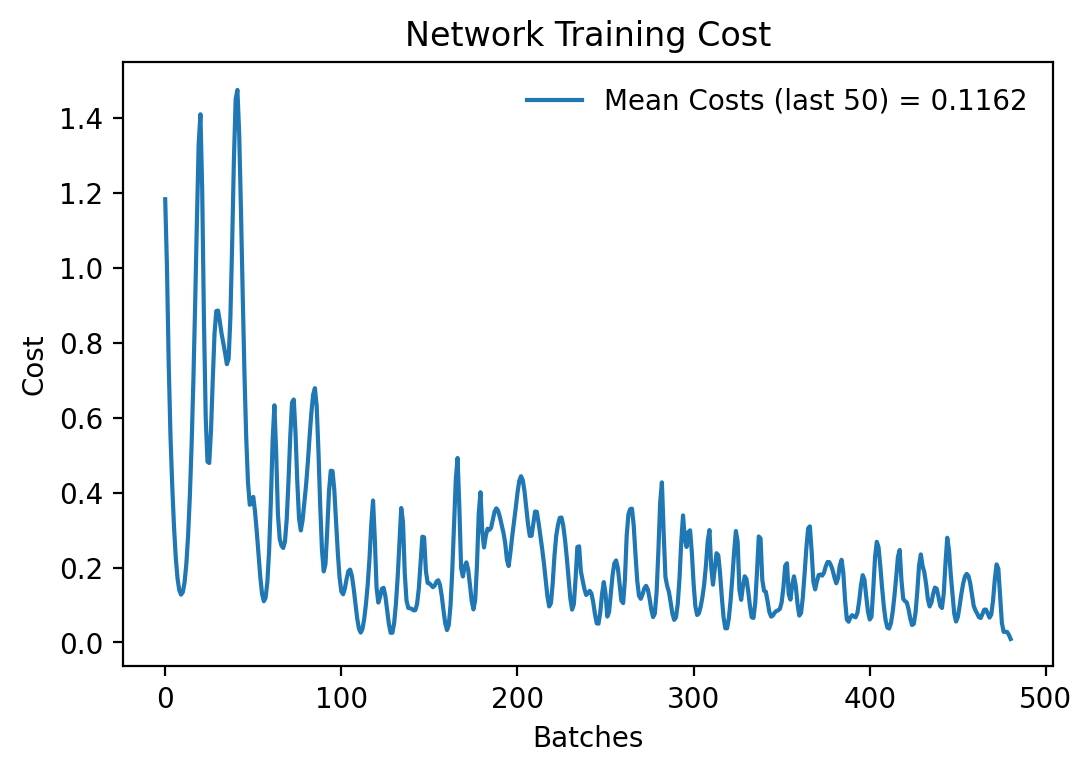

In [16]:
#adapted from Week6_Prediction.ipynb
batches=len(Input)#Number of batches
costs=np.zeros(batches)  #Array for plotting cost
for i in tqdm(range(batches)):
    In = Input[i].reshape(1,20, 4)
    Tar = Target[i].reshape(1,1, 4)
    costs[i]=model.train_on_batch(In, Tar) #Train the network

#Plot costs vs batches

fig,ax=plt.subplots()
ax.plot(np.arange(batches),costs,label=f"Mean Costs (last 50) = {np.mean(costs[-50:]):0.4f}")
ax.set_xlabel("Batches")
ax.set_ylabel("Cost")
ax.set_title("Network Training Cost")
ax.legend();

# Task 2
Using a large starting angle produced a worse cost statistic on training (c0.12). This is as expected as more complex motion will result in it being more difficult to train the model. Now the x1,y1,x2,y2 versus t plots were made

(481, 4)
[-0.75926131 -0.85892248 -1.66458333 -0.71942878]
[-0.7592613 -0.8589225 -1.6645833 -0.7194288]


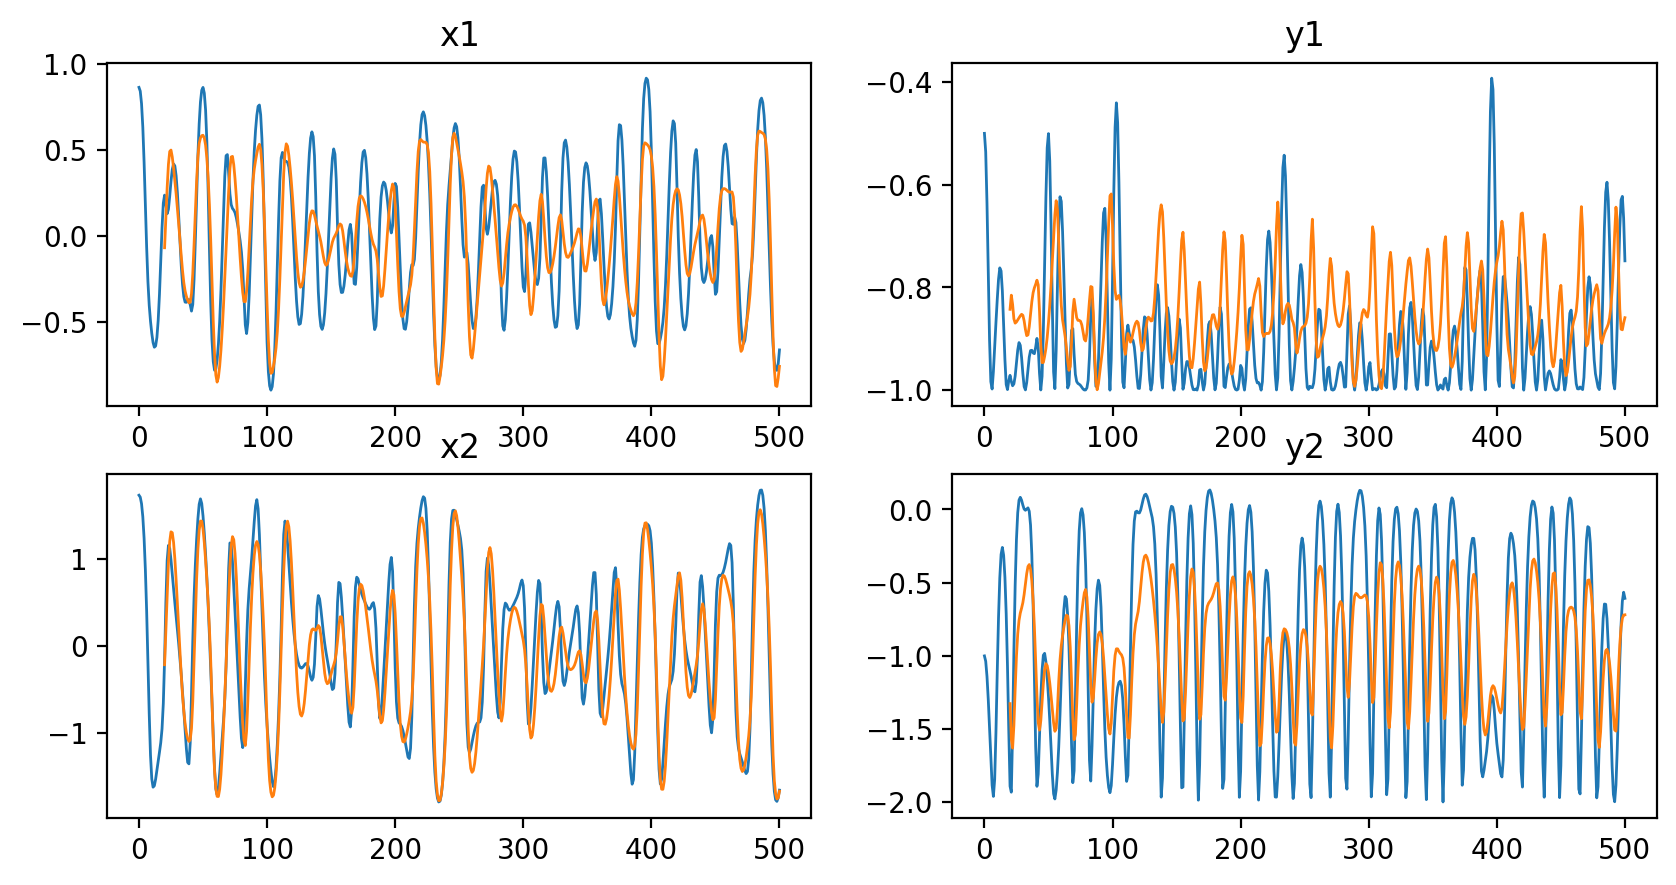

In [17]:
pred=np.zeros(len(Input)*4).reshape(len(Input),4)# array to collect model predictions
for i in range(len(Input)):
  y_in = Input[i].reshape(1,20, 4)
  y_out = model.predict_on_batch(y_in)
  pred[i] = y_out

print(pred.shape)#check it has worked
print(pred[-1])
print(y_out[0])

t = np.arange(501)#all t values
t_p = np.arange(481) +20 #t values from t=20, i.e. for predicted values

fig,ax = plt.subplots(ncols=2,nrows=2,figsize=(10,5))
ax[0,0].plot(t, pos[:,0], linewidth = 1)#from solv_ivp
ax[0,0].plot(t_p,pred[:,0], linewidth = 1)#from our model
ax[0,0].set_title('x1')

ax[0,1].plot(t, pos[:,1], linewidth = 1)
ax[0,1].plot(t_p,pred[:,1], linewidth = 1)
ax[0,1].set_title('y1')

ax[1,0].plot(t, pos[:,2], linewidth = 1)
ax[1,0].plot(t_p,pred[:,2], linewidth =1)
ax[1,0].set_title('x2')


ax[1,1].plot(t, pos[:,3], linewidth = 1)
ax[1,1].plot(t_p,pred[:,3], linewidth =1)
ax[1,1].set_title('y2');

# Task 2
For staring angles of $\pi/3$, more complex motion is exhibited and this leads to a worse cost function. The modelled results are failing to capture some of the more complex details, but are picking up many of the peaks and troughs. Again amplitudes are more accurate for x1, x2 than for y1, y2.

Overall conclusion is that the initial conditions can be changed and the model will adapt to the new values of x1,y1,x2,y2 it is training on. The accuracy of the model decreases as the starting angle increases as these will cause a more complex motion which is harder to model.

#Task 3
How far into the future can a network predict? Make a plot showing how the deviation between predicted position and actual position (from solve_ivp above) vary as a function of extrapolation time from $t=t_0 + 20 \delta t$ to $t=t_0 + 100 \delta t$  (e.g. for each extrapolation time, train a new version of the network and then plot the performance)

# Comments
For the deviations, m1 and m2 were considered separately and for each the sum of the square x and square y deviations were taken over the range of results. Then this sum was square rooted and divided by the number of obervations. The number of observations decreases as the window size increases. 

Two attempts at this problem were made: attempt 1 and attempt 2. The first attempt increased the window size for each iteration. So first the model was trained on the first 20 samples targeting the 21st, then 21 samples on the 22nd, etc. Thus the windowsize was increasing and so it was perhaps answering a different question: how does accuracy depend on windowsize? The results are kept out of interest and to show the development of my ideas.

In [19]:
# Set up the initial conditions. Here we have lengths and masses
L1, L2 = 1., 1.
m1, m2 = 3., 1.
g = 9.81     # [m/s^2]. Gravitational acceleration

#Starting angles
z0=[np.pi/4,0,np.pi/4,0]# change starting angles
#z0=[0.1,0,0.1,0]

#Time ranges
tmax, dt = 50, 0.1
t = np.arange(0, tmax+dt, dt)

# Solve initial value problem
ret = solve_ivp(rhs, (0,tmax), z0, t_eval=t, args=(L1, L2, m1, m2, g))
z=ret.y
print(np.shape(z))

# Extract result
theta1, w1, theta2, w2 = z[0], z[1], z[2], z[3]
x1, y1, x2, y2, vx1, vy1, vx2, vy2 = to_cartesian(theta1, w1, theta2, w2, L1, L2)

(4, 501)


In [20]:
# from https://numpy.org/doc/stable/reference/generated/numpy.stack.html#numpy.stack
pos = np.stack((x1,y1,x2,y2), axis=-1)#501 length array of x1, y1, x2, y2 values

#adapted from Week6_Prediction.ipynb
def shapeArray(x,windowsize):
    Input= np.array([x[i : i + windowsize] for i in range(len(x)-(windowsize))])
    Target= np.array([x[i+windowsize] for i in range(len(x)-(windowsize))])
    return (Input,Target)

first_window = 20
last_window = 101
m1_dev = np.zeros(last_window- first_window)#array to capture deviations in m1
m2_dev = np.zeros(last_window- first_window)#array to capture deviations in m1
c=0# counter for index of m1_dev and m2_dev

#loop over different window sizes
for windowsize in range(first_window,last_window,1): 
  
  # produce Input and Target arrays for each windowsize
  Input, Target = shapeArray(pos,windowsize)
  
  # model needs to be redefined and compiled for each windowsize
  model=keras.models.Sequential()
  model.add(keras.layers.LSTM(20,input_shape=(windowsize, 4), return_sequences=False))
  model.add(keras.layers.Dense(4,activation="linear"))# need 4 neurons to return the model values for x1, y1, x2, y2.
  model.compile(loss='mean_squared_error',optimizer='adam')

  #train the model for each windowsize
  batches=len(Input)#Number of batches
  costs=np.zeros(batches)  #Array for plotting cost
  for i in tqdm(range(batches)):
    In = Input[i].reshape(1,windowsize, 4)
    Tar = Target[i].reshape(1,1, 4)
    costs[i]=model.train_on_batch(In, Tar)

  # determine model predictions for each windowsize  
  pred=np.zeros(len(Input)*4).reshape(len(Input),4)# array to collect model predictions
  for i in range(len(Input)):
    y_in = Input[i].reshape(1,windowsize, 4)
    y_out = model.predict_on_batch(y_in)
    pred[i] = y_out
  
  # calculate deviations 
  m1_dev[c] = np.sum((pred[:,0] - pos[-len(pred):,0])**2 + (pred[:,1] - pos[-len(pred):,1])**2)**0.5/len(pred)
  m2_dev[c] = np.sum((pred[:,2] - pos[-len(pred):,2])**2 + (pred[:,3] - pos[-len(pred):,3])**2)**0.5/len(pred)

  c += 1


100%|██████████| 401/401 [00:11<00:00, 34.52it/s]


81


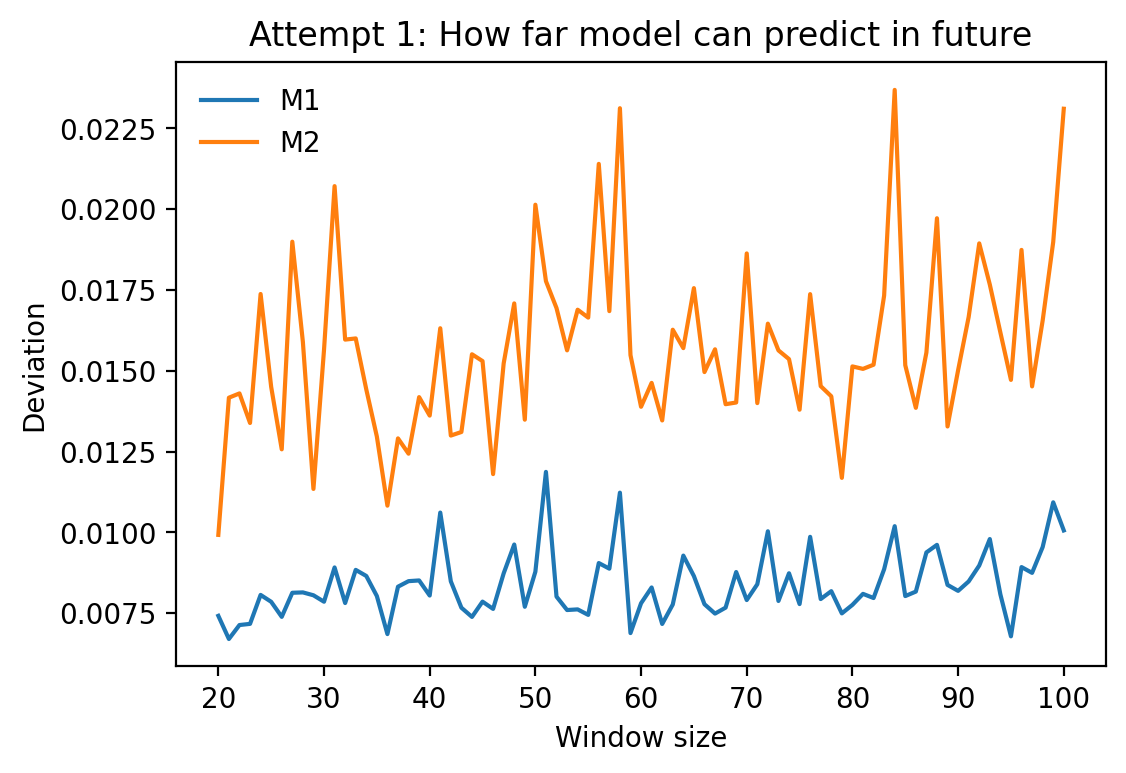

In [21]:
print(len(m1_dev))
w = np.arange(len(m1_dev)) + 20
fig,ax=plt.subplots()
ax.plot(w, m1_dev, label='M1')
ax.plot(w, m2_dev, label='M2')
ax.set_xlabel("Window size")
ax.set_ylabel("Deviation")
ax.set_title("Attempt 1: How far model can predict in future")
ax.legend();

#Task 3
As previously discussed, it may be that the wrong question has been answered. The window size has been increased from 20 to 100, but it is always the next values of x1,y1,x2,y2 which are the target.

There seems to be no advantage in increasing the windowsize above 20. The deviation plots are volatile, but the M2 plot does seem to be upward trending. Deviations are higher for M2, which is not surprising given its complex and larger range of motion.

For the second attempt, 20 wide sample windows were kept throughout and the model was trained first on the next sample. Deviations were evaluated and stored as previously. Then the offset was increased by one and the process repeated, etc.


In [36]:
# Set up the initial conditions. Here we have lengths and masses
L1, L2 = 1., 1.
m1, m2 = 3., 1.
g = 9.81     # [m/s^2]. Gravitational acceleration

#Starting angles
z0=[np.pi/4,0,np.pi/4,0]# change starting angles
#z0=[0.1,0,0.1,0]

#Time ranges
tmax, dt = 50, 0.1
t = np.arange(0, tmax+dt, dt)

# Solve initial value problem
ret = solve_ivp(rhs, (0,tmax), z0, t_eval=t, args=(L1, L2, m1, m2, g))
z=ret.y

# Extract result
theta1, w1, theta2, w2 = z[0], z[1], z[2], z[3]
x1, y1, x2, y2, vx1, vy1, vx2, vy2 = to_cartesian(theta1, w1, theta2, w2, L1, L2)

# from https://numpy.org/doc/stable/reference/generated/numpy.stack.html#numpy.stack
pos = np.stack((x1,y1,x2,y2), axis=-1)#501 length array of x1, y1, x2, y2 values
windowsize=20

#adapted from Week6_Prediction.ipynb
def shapeArray(x,windowsize,offset):
    Input= np.array([x[i : i + windowsize] for i in range(len(x)-windowsize-offset)])
    Target= np.array([x[i+windowsize+offset] for i in range(len(x)-windowsize-offset)])
    return (Input,Target)

first_offset = 0
last_offset = 80
m1_dev = np.zeros(last_offset- first_offset)#array to capture deviations in m1
m2_dev = np.zeros(last_offset- first_offset)#array to capture deviations in m1
c=0# counter for index of m1_dev and m2_dev

#loop over different offsets
for offset in range(first_offset,last_offset,1): 
  
  # produce Input and Target arrays for each windowsize
  Input, Target = shapeArray(pos,windowsize,offset)
  
  # model needs to be redefined and compiled for each windowsize
  model=keras.models.Sequential()
  model.add(keras.layers.LSTM(20,input_shape=(windowsize, 4), return_sequences=False))
  model.add(keras.layers.Dense(4,activation="linear"))# need 4 neurons to return the model values for x1, y1, x2, y2.
  model.compile(loss='mean_squared_error',optimizer='adam')

  #train the model for each windowsize
  batches=len(Input)#Number of batches
  costs=np.zeros(batches)  #Array for plotting cost
  for i in tqdm(range(batches)):
    In = Input[i].reshape(1,windowsize, 4)
    Tar = Target[i].reshape(1,1, 4)
    costs[i]=model.train_on_batch(In, Tar)

  # determine model predictions for each windowsize  
  pred=np.zeros(len(Input)*4).reshape(len(Input),4)# array to collect model predictions
  for i in range(len(Input)):
    y_in = Input[i].reshape(1,windowsize, 4)
    y_out = model.predict_on_batch(y_in)
    pred[i] = y_out
  
  # calculate deviations 
  m1_dev[c] = np.sum((pred[:,0] - pos[-len(pred):,0])**2 + (pred[:,1] - pos[-len(pred):,1])**2)**0.5/len(pred)
  m2_dev[c] = np.sum((pred[:,2] - pos[-len(pred):,2])**2 + (pred[:,3] - pos[-len(pred):,3])**2)**0.5/len(pred)

  #m2_dev[c] = ((np.sum(pred[:,2] - pos[-len(pred):,2])**2) + (np.sum(pred[:,3] - pos[-len(pred):,3])**2))**0.5/len(pred)
  c += 1

100%|██████████| 402/402 [00:05<00:00, 71.83it/s]


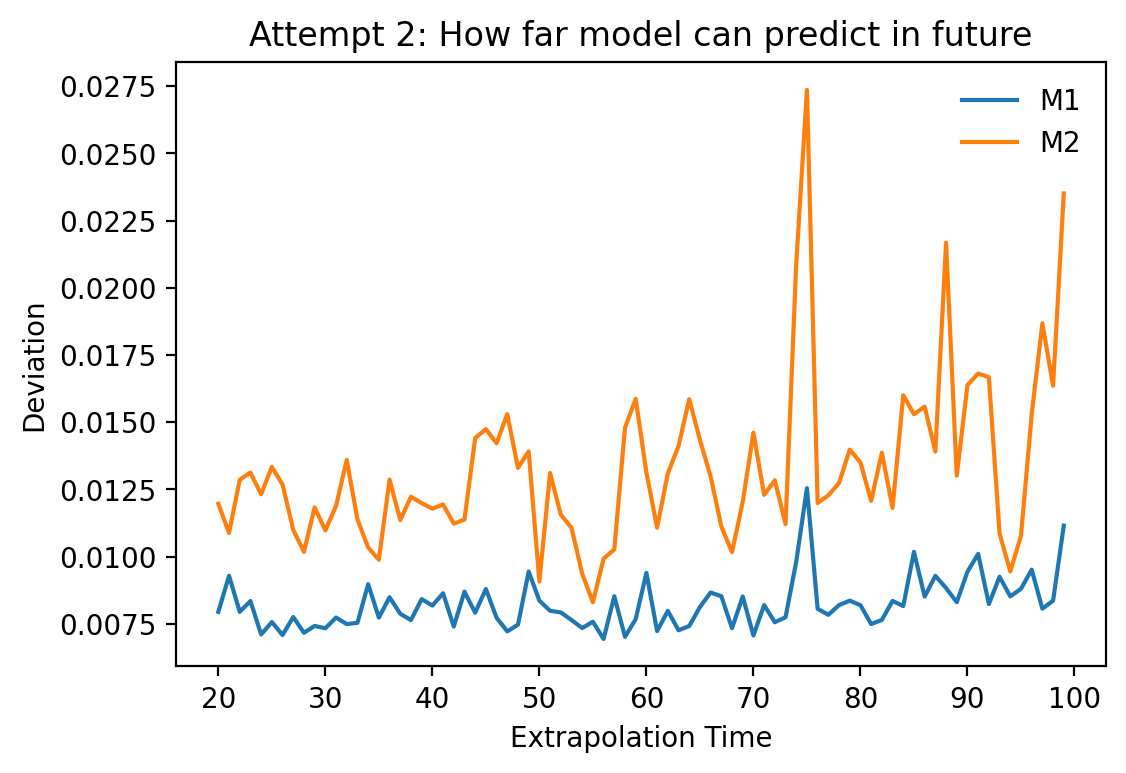

In [37]:
w = np.arange(len(m1_dev)) + 20
fig,ax=plt.subplots()
ax.plot(w, m1_dev, label='M1')
ax.plot(w, m2_dev, label='M2')
ax.set_xlabel("Extrapolation Time")
ax.set_ylabel("Deviation")
ax.set_title("Attempt 2: How far model can predict in future")
ax.legend();

# Task 3
Attempt 2 always uses a windowsize of 20, but extrapolates forward 20 to 100 time intervals. There is a slight uptrend in M2 deviations and both M1 and M2 have spikes around 75. This suggests that the model does a decent job up to 70 extrapolation time. As seen earlier in x1,y1,x2,y2 plots versus time the 20 sample window captures a large portion of one cycle of the motion, which might be why it works quite well on extrapolation. It might be harder to predict forward when the motion is more chaotic as should be the case in Task 4.

# Task 4. 
Repeat steps 1-3 for the initial conditions $z_0=[\pi/2,0,\pi/2,0]$ which give a much more complex path.
<p>Will name subtasks 4.1, 4.2, 4.3



# Task 4.1
The following code is copied from above with the initial conditions changed.

(4, 501)
Model: "sequential_246"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_246 (LSTM)             (None, 20)                2000      
                                                                 
 dense_246 (Dense)           (None, 4)                 84        
                                                                 
Total params: 2,084
Trainable params: 2,084
Non-trainable params: 0
_________________________________________________________________


100%|██████████| 481/481 [00:06<00:00, 69.88it/s] 


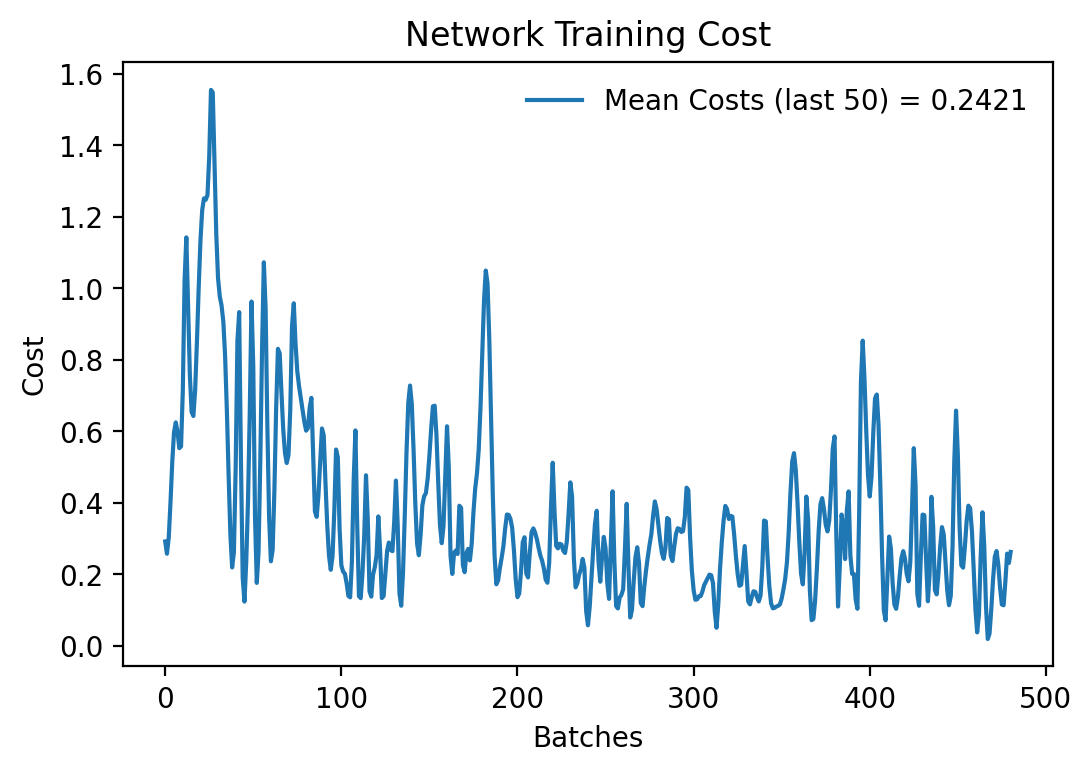

In [38]:
# Set up the initial conditions. Here we have lengths and masses
L1, L2 = 1., 1.
m1, m2 = 3., 1.
g = 9.81     # [m/s^2]. Gravitational acceleration

#Starting angles
z0=[np.pi/2,0,np.pi/2,0]# change starting angles
#z0=[0.1,0,0.1,0]

#Time ranges
tmax, dt = 50, 0.1
t = np.arange(0, tmax+dt, dt)

# Solve initial value problem
ret = solve_ivp(rhs, (0,tmax), z0, t_eval=t, args=(L1, L2, m1, m2, g))
z=ret.y
print(np.shape(z))

# Extract result
theta1, w1, theta2, w2 = z[0], z[1], z[2], z[3]
x1, y1, x2, y2, vx1, vy1, vx2, vy2 = to_cartesian(theta1, w1, theta2, w2, L1, L2)

# from https://numpy.org/doc/stable/reference/generated/numpy.stack.html#numpy.stack
pos = np.stack((x1,y1,x2,y2), axis=-1)#501 length array of x1, y1, x2, y2 values

#adapted from Week6_Prediction.ipynb
windowsize=20 #Number of samples we will use to train our network

#adapted from Week6_Prediction.ipynb
def shapeArray(x,windowsize):
    Input= np.array([x[i : i + windowsize] for i in range(len(x)-(windowsize))])
    #Target= np.array([x[i +windowsize] for i in range(len(x)-(windowsize)])
    Target= np.array([x[i+windowsize] for i in range(len(x)-(windowsize))])
    return (Input,Target)


#adapted from Week6_Prediction.ipynb
Input, Target = shapeArray(pos,windowsize)

#adapted from Week6_Prediction.ipynb
model=keras.models.Sequential()
model.add(keras.layers.LSTM(20,input_shape=(20, 4), return_sequences=False))#(20,4) represents the 20 wide window and 4 features
model.add(keras.layers.Dense(4,activation="linear"))# need 4 neurons to return the model values for x1, y1, x2, y2.
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

#adapted from Week6_Prediction.ipynb
batches=len(Input)#Number of batches
costs=np.zeros(batches)  #Array for plotting cost
for i in tqdm(range(batches)):
    In = Input[i].reshape(1,20, 4)
    Tar = Target[i].reshape(1,1, 4)
    costs[i]=model.train_on_batch(In, Tar) #Train the network

#Plot costs vs batches

fig,ax=plt.subplots()
ax.plot(np.arange(batches),costs,label=f"Mean Costs (last 50) = {np.mean(costs[-50:]):0.4f}")
ax.set_xlabel("Batches")
ax.set_ylabel("Cost")
ax.set_title("Network Training Cost")
ax.legend();



# Task 4.1
As expected, it is harder to train the model on the complex situation where the starting angles are so large.

# Task 4.2
In terms of variations in starting condition, this has already been tested in Task 2. It is clear that the accuracy of the models decreases when starting positions are higher as is also the case in Task 4.1.

Now the x,y plots versus time were made

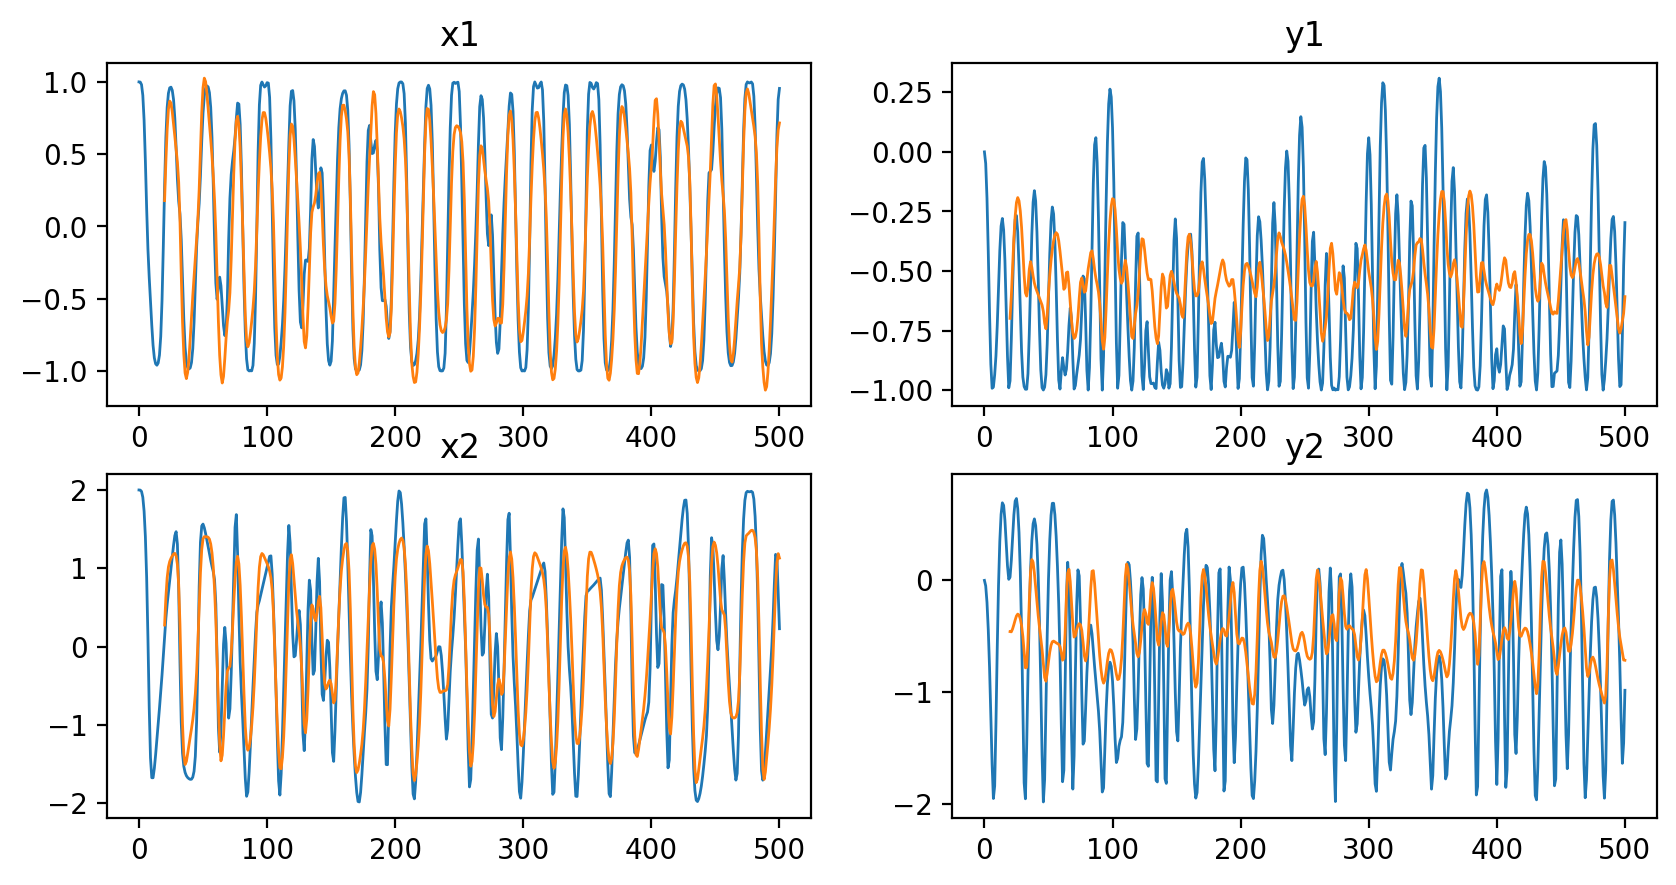

In [39]:
pred=np.zeros(len(Input)*4).reshape(len(Input),4)# array to collect model predictions
for i in range(len(Input)):
  y_in = Input[i].reshape(1,20, 4)
  y_out = model.predict_on_batch(y_in)
  pred[i] = y_out

t = np.arange(501)#all t values
t_p = np.arange(481) +20 #t values from t=20, i.e. for predicted values

fig,ax = plt.subplots(ncols=2,nrows=2,figsize=(10,5))
ax[0,0].plot(t, pos[:,0], linewidth = 1)#from solv_ivp
ax[0,0].plot(t_p,pred[:,0], linewidth = 1)#from our model
ax[0,0].set_title('x1')

ax[0,1].plot(t, pos[:,1], linewidth = 1)
ax[0,1].plot(t_p,pred[:,1], linewidth = 1)
ax[0,1].set_title('y1')

ax[1,0].plot(t, pos[:,2], linewidth = 1)
ax[1,0].plot(t_p,pred[:,2], linewidth =1)
ax[1,0].set_title('x2')


ax[1,1].plot(t, pos[:,3], linewidth = 1)
ax[1,1].plot(t_p,pred[:,3], linewidth =1)
ax[1,1].set_title('y2');

# Task 4.2
More chaotic motion is shown in solv_ivp plots (blue), and the model fails to capture all of the peaks and troughs. As before amplitude fitting is better for x values than y values. So in line with worse cost function model performance is worse than for $\pi/4$ starting angle.

# Task 4.3
Attempt 2 from Task 3 was adapted for use.

100%|██████████| 402/402 [00:05<00:00, 70.84it/s]


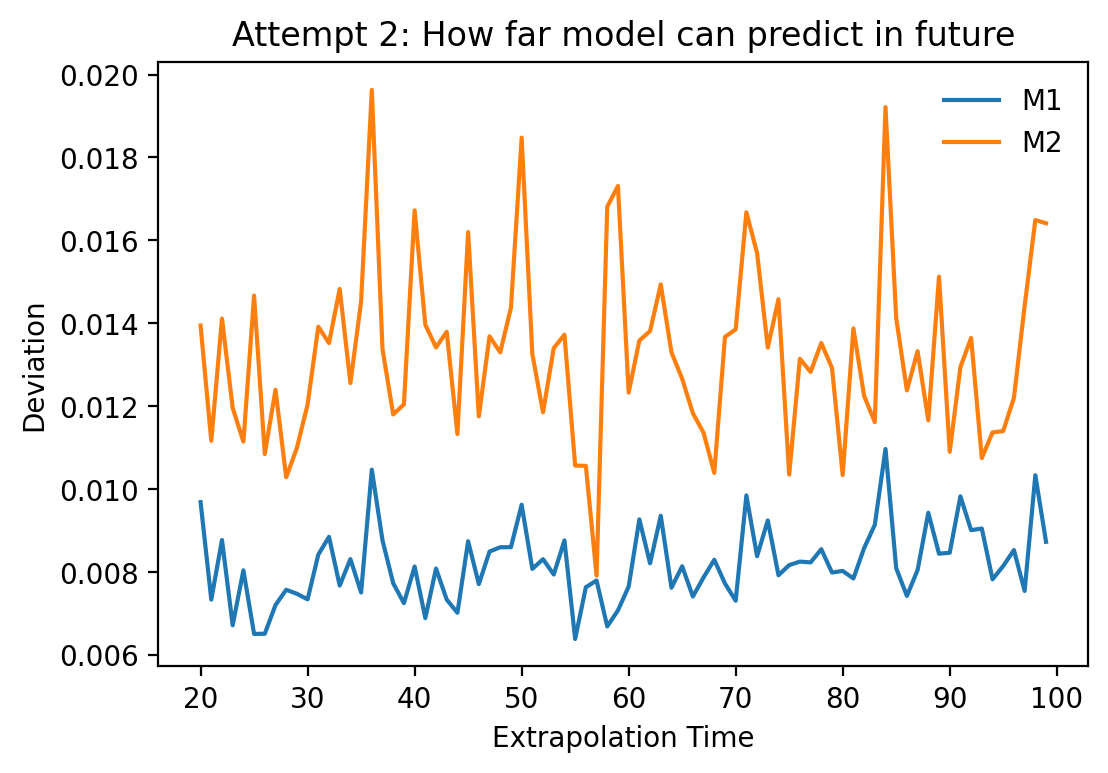

In [40]:
# Set up the initial conditions. Here we have lengths and masses
L1, L2 = 1., 1.
m1, m2 = 3., 1.
g = 9.81     # [m/s^2]. Gravitational acceleration

#Starting angles
z0=[np.pi/4,0,np.pi/4,0]# change starting angles
#z0=[0.1,0,0.1,0]

#Time ranges
tmax, dt = 50, 0.1
t = np.arange(0, tmax+dt, dt)

# Solve initial value problem
ret = solve_ivp(rhs, (0,tmax), z0, t_eval=t, args=(L1, L2, m1, m2, g))
z=ret.y

# Extract result
theta1, w1, theta2, w2 = z[0], z[1], z[2], z[3]
x1, y1, x2, y2, vx1, vy1, vx2, vy2 = to_cartesian(theta1, w1, theta2, w2, L1, L2)

# from https://numpy.org/doc/stable/reference/generated/numpy.stack.html#numpy.stack
pos = np.stack((x1,y1,x2,y2), axis=-1)#501 length array of x1, y1, x2, y2 values
windowsize = 20
#adapted from Week6_Prediction.ipynb
def shapeArray(x,windowsize,offset):
    Input= np.array([x[i : i + windowsize] for i in range(len(x)-windowsize-offset)])
    Target= np.array([x[i+windowsize+offset] for i in range(len(x)-windowsize-offset)])
    return (Input,Target)

first_offset = 0
last_offset = 80
m1_dev = np.zeros(last_offset- first_offset)#array to capture deviations in m1
m2_dev = np.zeros(last_offset- first_offset)#array to capture deviations in m1
c=0# counter for index of m1_dev and m2_dev

#loop over different window sizes
for offset in range(first_offset,last_offset,1): 
  
  # produce Input and Target arrays for each windowsize
  Input, Target = shapeArray(pos,windowsize,offset)
  
  # model needs to be redefined and compiled for each windowsize
  model=keras.models.Sequential()
  model.add(keras.layers.LSTM(20,input_shape=(windowsize, 4), return_sequences=False))
  model.add(keras.layers.Dense(4,activation="linear"))# need 4 neurons to return the model values for x1, y1, x2, y2.
  model.compile(loss='mean_squared_error',optimizer='adam')

  #train the model for each windowsize
  batches=len(Input)#Number of batches
  costs=np.zeros(batches)  #Array for plotting cost
  for i in tqdm(range(batches)):
    In = Input[i].reshape(1,windowsize, 4)
    Tar = Target[i].reshape(1,1, 4)
    costs[i]=model.train_on_batch(In, Tar)

  # determine model predictions for each windowsize  
  pred=np.zeros(len(Input)*4).reshape(len(Input),4)# array to collect model predictions
  for i in range(len(Input)):
    y_in = Input[i].reshape(1,windowsize, 4)
    y_out = model.predict_on_batch(y_in)
    pred[i] = y_out
  
  # calculate deviations 
  m1_dev[c] = np.sum((pred[:,0] - pos[-len(pred):,0])**2 + (pred[:,1] - pos[-len(pred):,1])**2)**0.5/len(pred)
  m2_dev[c] = np.sum((pred[:,2] - pos[-len(pred):,2])**2 + (pred[:,3] - pos[-len(pred):,3])**2)**0.5/len(pred)

  c += 1

w = np.arange(len(m1_dev)) + 20
fig,ax=plt.subplots()
ax.plot(w, m1_dev, label='M1')
ax.plot(w, m2_dev, label='M2')
ax.set_xlabel("Extrapolation Time")
ax.set_ylabel("Deviation")
ax.set_title("Attempt 2: How far model can predict in future")
ax.legend();

# Task 4.3
The model generally predicts fairly well up to an extrapolation time of 30. Thereafter, the deviations have some sharp spikes, particularly for M2 around 37, 50 and 85. As expected due to the more complex nature of the motion, extrapolation of the model is less successful. (In task 3, it predicted well up to an extrapolation time of 70).

# Task 4 complete

# Task 5
Training was run just using m2, i.e the features x2,y2.
With this set-up, it was required to run through Tasks 1-4 and Task 4 requires a rerun of Tasks 1-3. So just for clarity, the task were denoted as follows: 5.1, 5.2, 5.3, 5.4.1, 5.4.2, 5.4.3

#Task 5.1
First, it was required to adapt the model, inputs and targets as follows:

## Position Array
Position state of system described by $x_2, y_2$: (501, 2) array.

## Training Input
Array shape: (481,20,2)

## Training Target 
Array shape: (481,1,2)

## LSTM model
Input shape changed in LSTM layer to (20,2)
Dense layer neurons changed to 2 to match x2,y2

(4, 501)
Model: "sequential_327"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_327 (LSTM)             (None, 20)                1840      
                                                                 
 dense_327 (Dense)           (None, 2)                 42        
                                                                 
Total params: 1,882
Trainable params: 1,882
Non-trainable params: 0
_________________________________________________________________


100%|██████████| 481/481 [00:06<00:00, 70.69it/s]


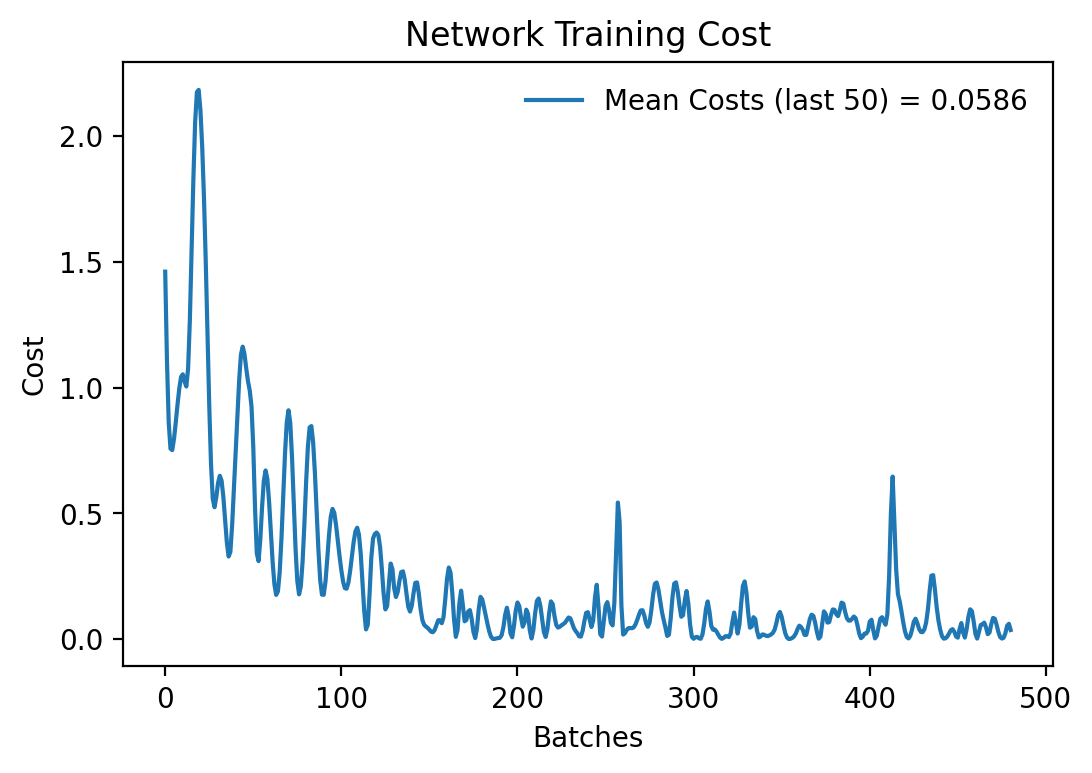

In [41]:
# Set up the initial conditions. Here we have lengths and masses
L1, L2 = 1., 1.
m1, m2 = 3., 1.
g = 9.81     # [m/s^2]. Gravitational acceleration

#Starting angles
z0=[np.pi/4,0,np.pi/4,0]# change starting angles
#z0=[0.1,0,0.1,0]

#Time ranges
tmax, dt = 50, 0.1
t = np.arange(0, tmax+dt, dt)

# Solve initial value problem
ret = solve_ivp(rhs, (0,tmax), z0, t_eval=t, args=(L1, L2, m1, m2, g))
z=ret.y
print(np.shape(z))

# Extract result
theta1, w1, theta2, w2 = z[0], z[1], z[2], z[3]
x1, y1, x2, y2, vx1, vy1, vx2, vy2 = to_cartesian(theta1, w1, theta2, w2, L1, L2)

# from https://numpy.org/doc/stable/reference/generated/numpy.stack.html#numpy.stack
pos = np.stack((x2,y2), axis=-1)#501 length array of x2, y2 values

#adapted from Week6_Prediction.ipynb
windowsize=20 #Number of samples we will use to train our network

#adapted from Week6_Prediction.ipynb
def shapeArray(x,windowsize):
    Input= np.array([x[i : i + windowsize] for i in range(len(x)-(windowsize))])
    Target= np.array([x[i+windowsize] for i in range(len(x)-(windowsize))])
    return (Input,Target)


#adapted from Week6_Prediction.ipynb
Input, Target = shapeArray(pos,windowsize)

#adapted from Week6_Prediction.ipynb
model=keras.models.Sequential()
model.add(keras.layers.LSTM(20,input_shape=(20, 2), return_sequences=False))#(20,2) represents the 20 wide window and 2 features
model.add(keras.layers.Dense(2,activation="linear"))# need 2 neurons to return the model values for x2, y2.
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

#adapted from Week6_Prediction.ipynb
batches=len(Input)#Number of batches
costs=np.zeros(batches)  #Array for plotting cost
for i in tqdm(range(batches)):
    In = Input[i].reshape(1,20, 2)#now only 2 features
    Tar = Target[i].reshape(1,1, 2)#now only 2 features
    costs[i]=model.train_on_batch(In, Tar) #Train the network

#Plot costs vs batches

fig,ax=plt.subplots()
ax.plot(np.arange(batches),costs,label=f"Mean Costs (last 50) = {np.mean(costs[-50:]):0.4f}")
ax.set_xlabel("Batches")
ax.set_ylabel("Cost")
ax.set_title("Network Training Cost")
ax.legend();



# Task 5.1
The position of M2 is anchored off M1, and so losing information about M1 should make the model training harder. Cost measure in Task 1 was 0.0326, so this was the case.

#Task 5.2
As before, the second part of the task was done first: plot x2,y2 as a function of time

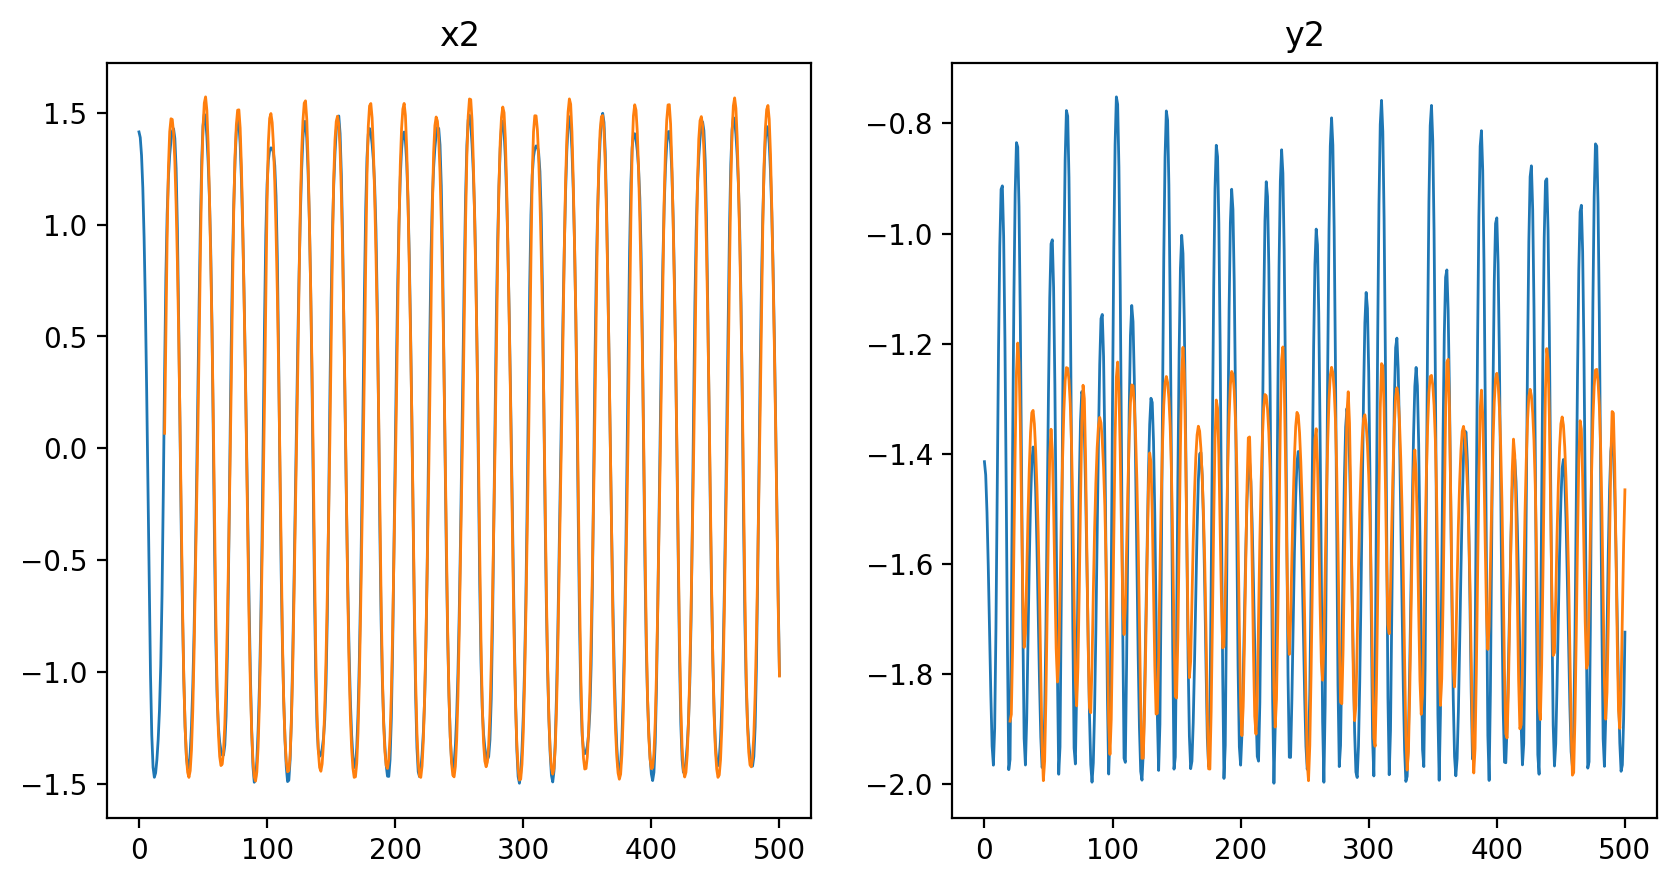

In [42]:
pred=np.zeros(len(Input)*2).reshape(len(Input),2)# only two features
for i in range(len(Input)):
  y_in = Input[i].reshape(1,20,2)
  y_out = model.predict_on_batch(y_in)
  pred[i] = y_out


t = np.arange(501)#all t values
t_p = np.arange(481) +20 #t values from t=20, i.e. for predicted values

fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(10,5))
ax[0].plot(t, pos[:,0], linewidth = 1)#from solv_ivp
ax[0].plot(t_p,pred[:,0], linewidth = 1)#from our model
ax[0].set_title('x2')

ax[1].plot(t, pos[:,1], linewidth = 1)
ax[1].plot(t_p,pred[:,1], linewidth = 1)
ax[1].set_title('y2');


# Task 5.2
Model has acheived quite a close fit for x2. y2 plot shows that the model is capturing the turning points but amplitudes are wrong for y2. These are  similar observations to Task 2

To answer the first part of Task 5.2, it was decided to vary the initial conditions and have very small angles of $\pi/8$

(4, 501)
Model: "sequential_328"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_328 (LSTM)             (None, 20)                1840      
                                                                 
 dense_328 (Dense)           (None, 2)                 42        
                                                                 
Total params: 1,882
Trainable params: 1,882
Non-trainable params: 0
_________________________________________________________________


100%|██████████| 481/481 [00:07<00:00, 64.85it/s]


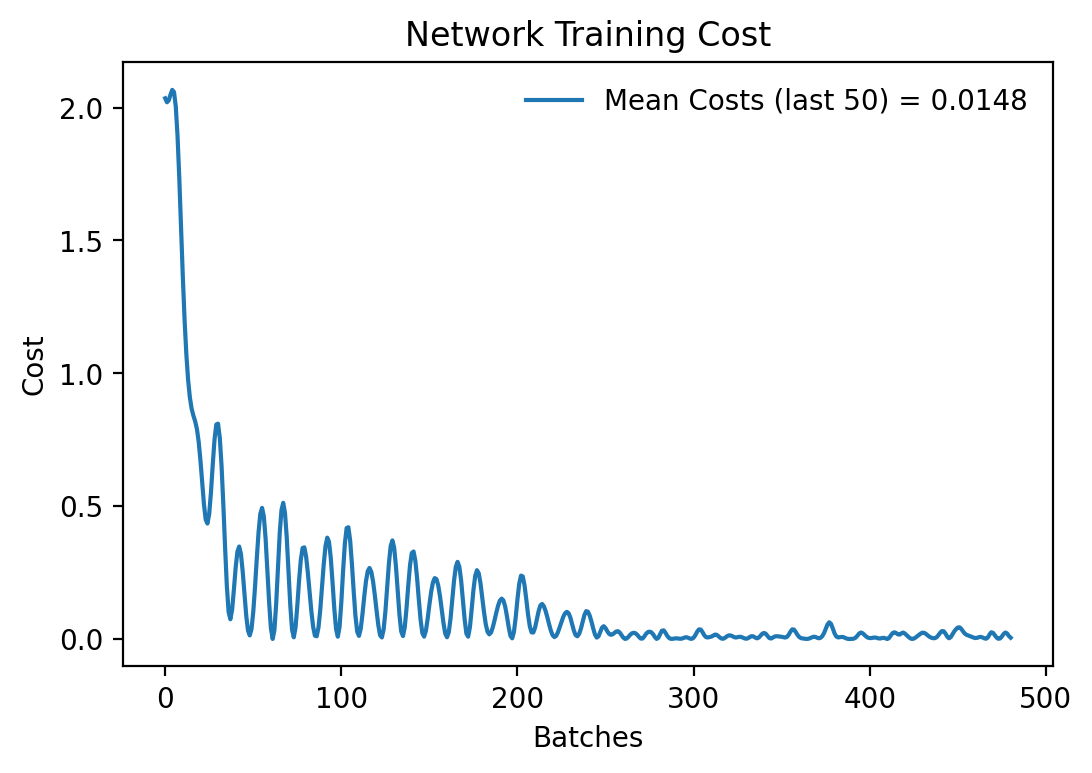

In [43]:
# Set up the initial conditions. Here we have lengths and masses
L1, L2 = 1., 1.
m1, m2 = 3., 1.
g = 9.81     # [m/s^2]. Gravitational acceleration

#Starting angles
z0=[np.pi/8,0,np.pi/8,0]# change starting angles
#z0=[0.1,0,0.1,0]

#Time ranges
tmax, dt = 50, 0.1
t = np.arange(0, tmax+dt, dt)

# Solve initial value problem
ret = solve_ivp(rhs, (0,tmax), z0, t_eval=t, args=(L1, L2, m1, m2, g))
z=ret.y
print(np.shape(z))

# Extract result
theta1, w1, theta2, w2 = z[0], z[1], z[2], z[3]
x1, y1, x2, y2, vx1, vy1, vx2, vy2 = to_cartesian(theta1, w1, theta2, w2, L1, L2)

# from https://numpy.org/doc/stable/reference/generated/numpy.stack.html#numpy.stack
pos = np.stack((x2,y2), axis=-1)#501 length array of x2, y2 values

#adapted from Week6_Prediction.ipynb
windowsize=20 #Number of samples we will use to train our network

#adapted from Week6_Prediction.ipynb
def shapeArray(x,windowsize):
    Input= np.array([x[i : i + windowsize] for i in range(len(x)-(windowsize))])
    Target= np.array([x[i+windowsize] for i in range(len(x)-(windowsize))])
    return (Input,Target)


#adapted from Week6_Prediction.ipynb
Input, Target = shapeArray(pos,windowsize)

#adapted from Week6_Prediction.ipynb
model=keras.models.Sequential()
model.add(keras.layers.LSTM(20,input_shape=(20, 2), return_sequences=False))#(20,2) represents the 20 wide window and 2 features
model.add(keras.layers.Dense(2,activation="linear"))# need 2 neurons to return the model values for x2, y2.
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

#adapted from Week6_Prediction.ipynb
batches=len(Input)#Number of batches
costs=np.zeros(batches)  #Array for plotting cost
for i in tqdm(range(batches)):
    In = Input[i].reshape(1,20, 2)#now only 2 features
    Tar = Target[i].reshape(1,1, 2)#now only 2 features
    costs[i]=model.train_on_batch(In, Tar) #Train the network

#Plot costs vs batches

fig,ax=plt.subplots()
ax.plot(np.arange(batches),costs,label=f"Mean Costs (last 50) = {np.mean(costs[-50:]):0.4f}")
ax.set_xlabel("Batches")
ax.set_ylabel("Cost")
ax.set_title("Network Training Cost")
ax.legend();

# Task 5.2
As before this model adapts well to changes in initial conditions and produces a lower cost measure when the initial angles are small. This compares to a cost measure of 0.0117 for the same initial angle in Task 2. In this situation, perhaps the more simple motion of m2 is easier to model and the lack of x1, y1 in the model has less effect than for $\pi/4$.  

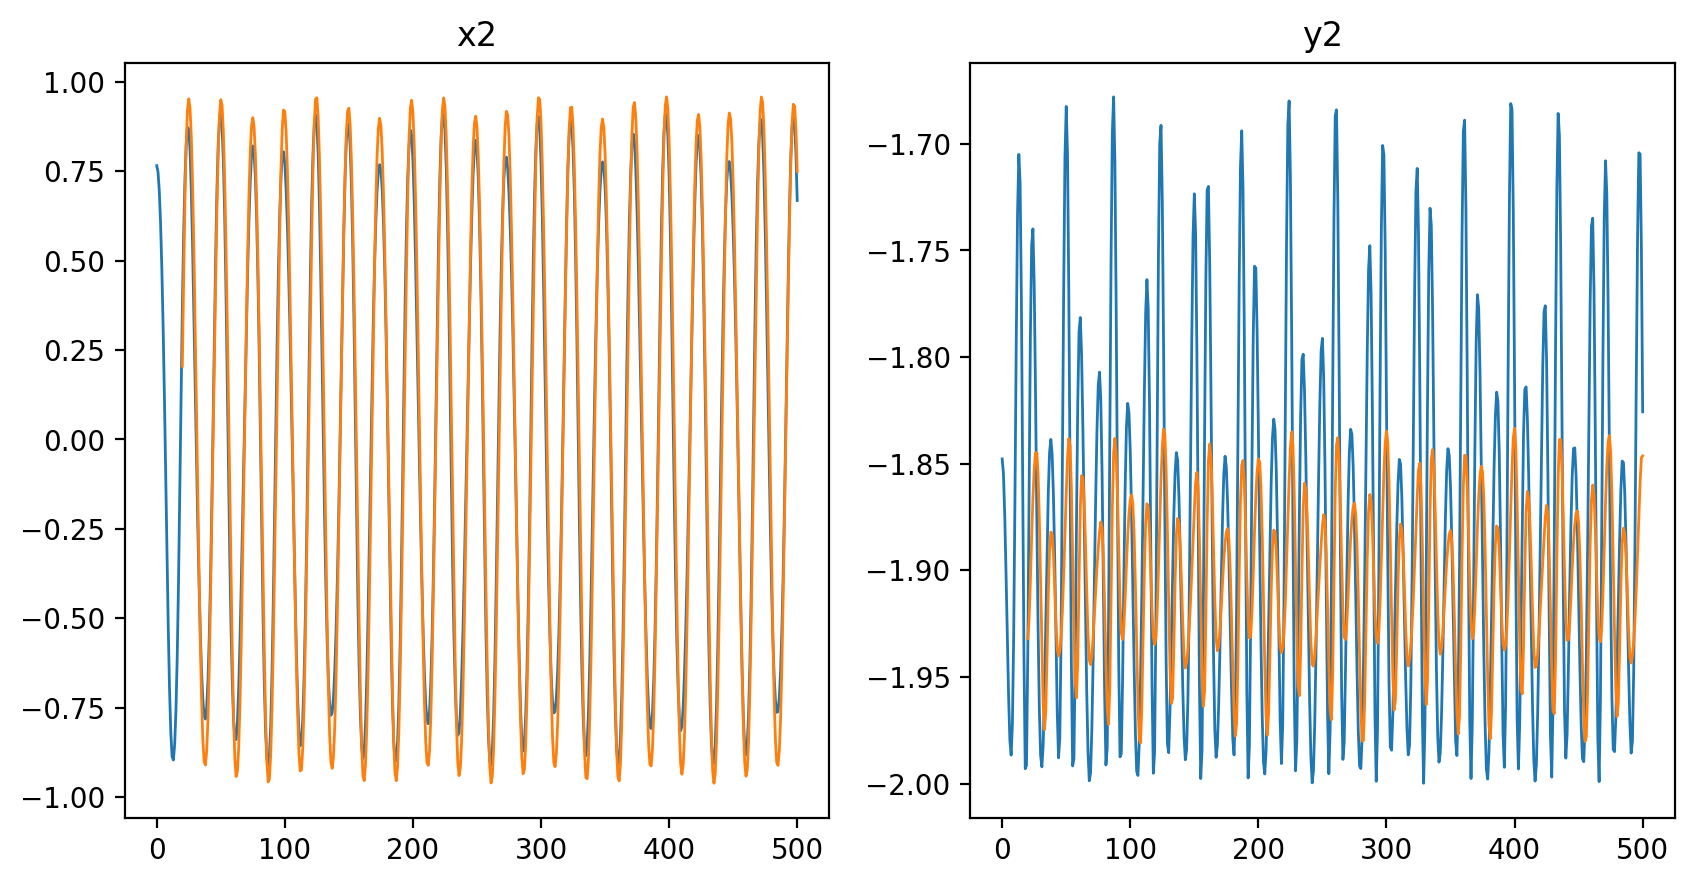

In [44]:
pred=np.zeros(len(Input)*2).reshape(len(Input),2)# only two features
for i in range(len(Input)):
  y_in = Input[i].reshape(1,20,2)
  y_out = model.predict_on_batch(y_in)
  pred[i] = y_out


t = np.arange(501)#all t values
t_p = np.arange(481) +20 #t values from t=20, i.e. for predicted values

fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(10,5))
ax[0].plot(t, pos[:,0], linewidth = 1)#from solv_ivp
ax[0].plot(t_p,pred[:,0], linewidth = 1)#from our model
ax[0].set_title('x2')

ax[1].plot(t, pos[:,1], linewidth = 1)
ax[1].plot(t_p,pred[:,1], linewidth = 1)
ax[1].set_title('y2');


# Task 5.2
A fairly good fit was obtained for x2. y2 is capturing the periodicty of solv_ivp line, but the peaks and troughs are a little out of phase and as has often been the case the amplitudes of y2 motion are less than they should be.

Now it was decided to try $3\pi/4$

(4, 501)
Model: "sequential_329"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_329 (LSTM)             (None, 20)                1840      
                                                                 
 dense_329 (Dense)           (None, 2)                 42        
                                                                 
Total params: 1,882
Trainable params: 1,882
Non-trainable params: 0
_________________________________________________________________


100%|██████████| 481/481 [00:06<00:00, 74.01it/s] 


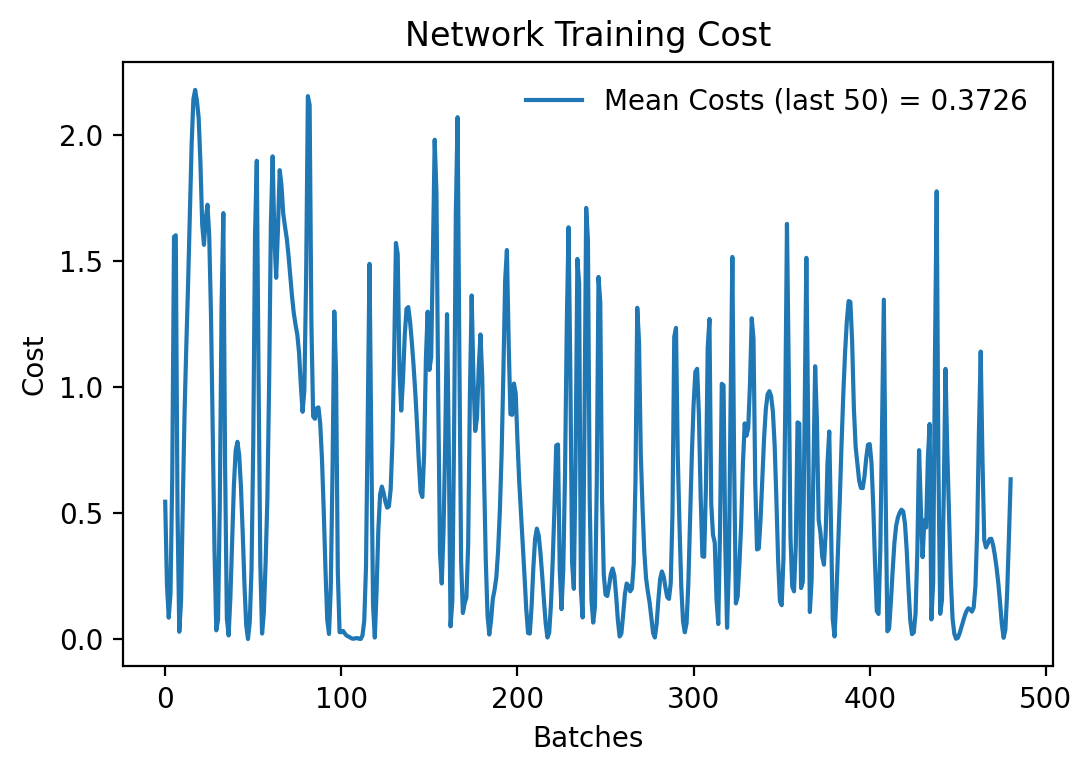

In [45]:
# Set up the initial conditions. Here we have lengths and masses
L1, L2 = 1., 1.
m1, m2 = 3., 1.
g = 9.81     # [m/s^2]. Gravitational acceleration

#Starting angles
z0=[3*np.pi/4,0,3*np.pi/4,0]# change starting angles
#z0=[0.1,0,0.1,0]

#Time ranges
tmax, dt = 50, 0.1
t = np.arange(0, tmax+dt, dt)

# Solve initial value problem
ret = solve_ivp(rhs, (0,tmax), z0, t_eval=t, args=(L1, L2, m1, m2, g))
z=ret.y
print(np.shape(z))

# Extract result
theta1, w1, theta2, w2 = z[0], z[1], z[2], z[3]
x1, y1, x2, y2, vx1, vy1, vx2, vy2 = to_cartesian(theta1, w1, theta2, w2, L1, L2)

# from https://numpy.org/doc/stable/reference/generated/numpy.stack.html#numpy.stack
pos = np.stack((x2,y2), axis=-1)#501 length array of x2, y2 values

#adapted from Week6_Prediction.ipynb
windowsize=20 #Number of samples we will use to train our network

#adapted from Week6_Prediction.ipynb
def shapeArray(x,windowsize):
    Input= np.array([x[i : i + windowsize] for i in range(len(x)-(windowsize))])
    Target= np.array([x[i+windowsize] for i in range(len(x)-(windowsize))])
    return (Input,Target)


#adapted from Week6_Prediction.ipynb
Input, Target = shapeArray(pos,windowsize)

#adapted from Week6_Prediction.ipynb
model=keras.models.Sequential()
model.add(keras.layers.LSTM(20,input_shape=(20, 2), return_sequences=False))#(20,2) represents the 20 wide window and 2 features
model.add(keras.layers.Dense(2,activation="linear"))# need 2 neurons to return the model values for x2, y2.
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

#adapted from Week6_Prediction.ipynb
batches=len(Input)#Number of batches
costs=np.zeros(batches)  #Array for plotting cost
for i in tqdm(range(batches)):
    In = Input[i].reshape(1,20, 2)#now only 2 features
    Tar = Target[i].reshape(1,1, 2)#now only 2 features
    costs[i]=model.train_on_batch(In, Tar) #Train the network

#Plot costs vs batches

fig,ax=plt.subplots()
ax.plot(np.arange(batches),costs,label=f"Mean Costs (last 50) = {np.mean(costs[-50:]):0.4f}")
ax.set_xlabel("Batches")
ax.set_ylabel("Cost")
ax.set_title("Network Training Cost")
ax.legend();

# Task 5.2
Unsurprising given such large angles, the model really does not train very well and the cost function does not converge.

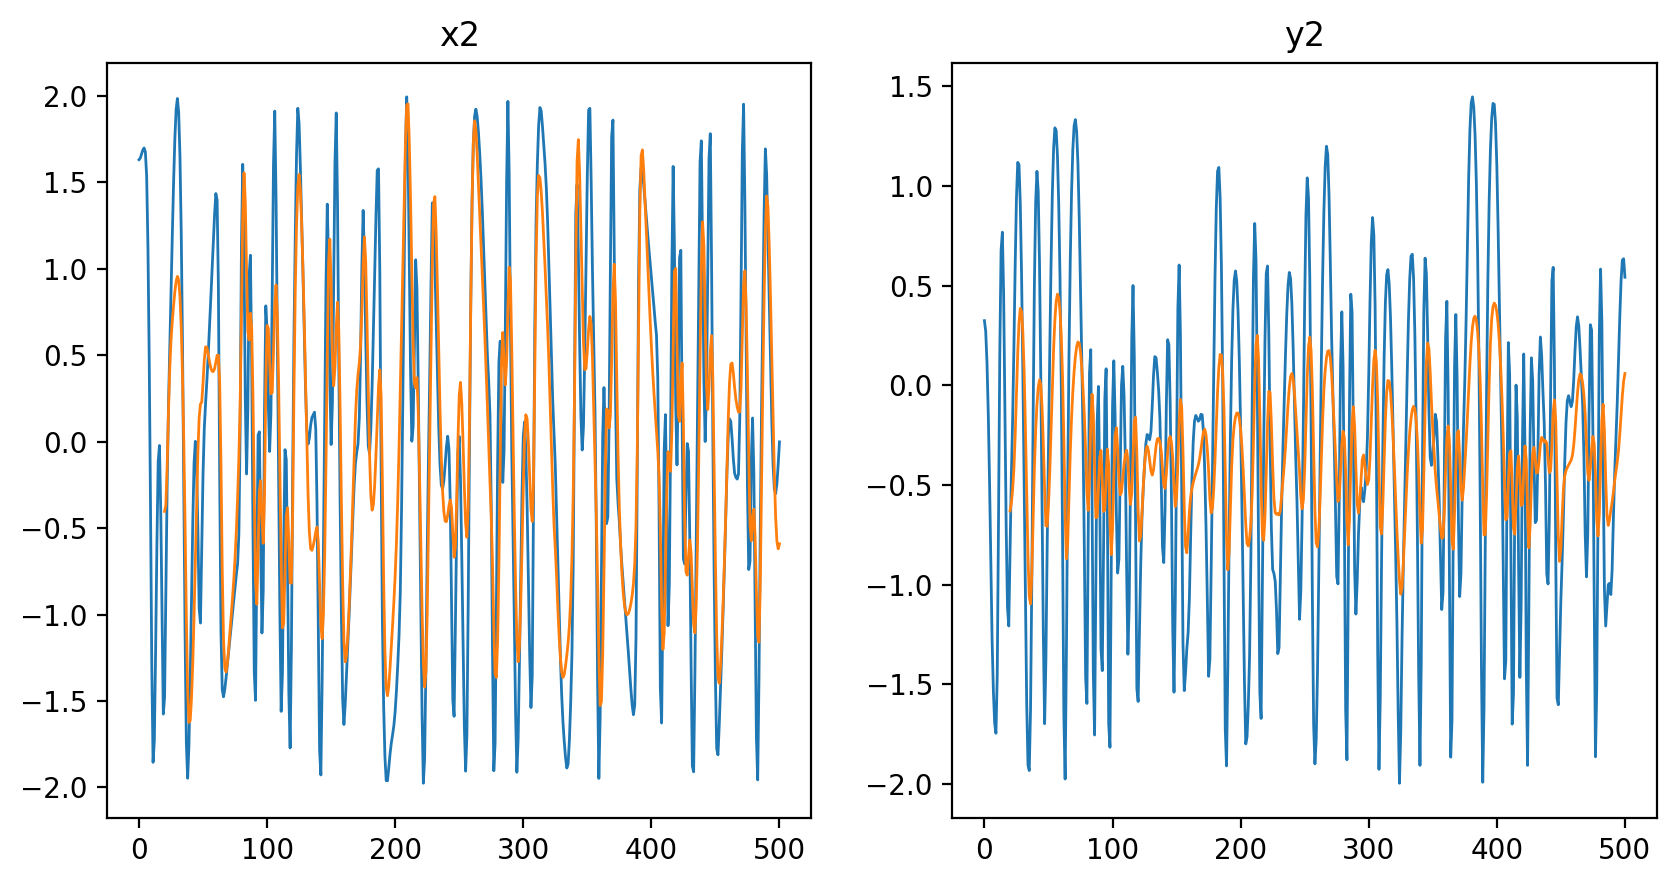

In [ ]:
pred=np.zeros(len(Input)*2).reshape(len(Input),2)# only two features
for i in range(len(Input)):
  y_in = Input[i].reshape(1,20,2)
  y_out = model.predict_on_batch(y_in)
  pred[i] = y_out


t = np.arange(501)#all t values
t_p = np.arange(481) +20 #t values from t=20, i.e. for predicted values

fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(10,5))
ax[0].plot(t, pos[:,0], linewidth = 1)#from solv_ivp
ax[0].plot(t_p,pred[:,0], linewidth = 1)#from our model
ax[0].set_title('x2')

ax[1].plot(t, pos[:,1], linewidth = 1)
ax[1].plot(t_p,pred[:,1], linewidth = 1)
ax[1].set_title('y2');

# Task 5.2
A very complex solv_ivp plot, which the model struggles to follow.

# Task 5.2 complete

# Task 5.3


In [47]:
# Set up the initial conditions. Here we have lengths and masses
L1, L2 = 1., 1.
m1, m2 = 3., 1.
g = 9.81     # [m/s^2]. Gravitational acceleration

#Starting angles
z0=[np.pi/4,0,np.pi/4,0]# change starting angles
#z0=[0.1,0,0.1,0]

#Time ranges
tmax, dt = 50, 0.1
t = np.arange(0, tmax+dt, dt)

# Solve initial value problem
ret = solve_ivp(rhs, (0,tmax), z0, t_eval=t, args=(L1, L2, m1, m2, g))
z=ret.y

# Extract result
theta1, w1, theta2, w2 = z[0], z[1], z[2], z[3]
x1, y1, x2, y2, vx1, vy1, vx2, vy2 = to_cartesian(theta1, w1, theta2, w2, L1, L2)

# from https://numpy.org/doc/stable/reference/generated/numpy.stack.html#numpy.stack
pos = np.stack((x2,y2), axis=-1)#501 length array of x2, y2 values
windowsize = 20
#adapted from Week6_Prediction.ipynb
def shapeArray(x,windowsize,offset):
    Input= np.array([x[i : i + windowsize] for i in range(len(x)-windowsize-offset)])
    Target= np.array([x[i+windowsize+offset] for i in range(len(x)-windowsize-offset)])
    return (Input,Target)

first_offset = 0
last_offset = 80

m2_dev = np.zeros(last_offset- first_offset)#array to capture deviations in m2
c=0# counter for index of m1_dev and m2_dev

#loop over different window sizes
for offset in range(first_offset,last_offset,1): 
  
  # produce Input and Target arrays for each windowsize
  Input, Target = shapeArray(pos,windowsize,offset)
  
  # model needs to be redefined and compiled for each windowsize
  model=keras.models.Sequential()
  model.add(keras.layers.LSTM(20,input_shape=(windowsize, 2), return_sequences=False))
  model.add(keras.layers.Dense(2,activation="linear"))# need 4 neurons to return the model values forx2, y2.
  model.compile(loss='mean_squared_error',optimizer='adam')

  #train the model for each windowsize
  batches=len(Input)#Number of batches
  costs=np.zeros(batches)  #Array for plotting cost
  for i in tqdm(range(batches)):
    In = Input[i].reshape(1,windowsize, 2)
    Tar = Target[i].reshape(1,1, 2)
    costs[i]=model.train_on_batch(In, Tar)

  # determine model predictions for each windowsize  
  pred=np.zeros(len(Input)*2).reshape(len(Input),2)# array to collect model predictions
  for i in range(len(Input)):
    y_in = Input[i].reshape(1,windowsize, 2)
    y_out = model.predict_on_batch(y_in)
    pred[i] = y_out
  
  # calculate deviations 
  m2_dev[c] = np.sum((pred[:,0] - pos[-len(pred):,0])**2 + (pred[:,1] - pos[-len(pred):,1])**2)**0.5/len(pred)
 

  #m2_dev[c] = ((np.sum(pred[:,2] - pos[-len(pred):,2])**2) + (np.sum(pred[:,3] - pos[-len(pred):,3])**2))**0.5/len(pred)
  c += 1



100%|██████████| 402/402 [00:05<00:00, 70.44it/s] 


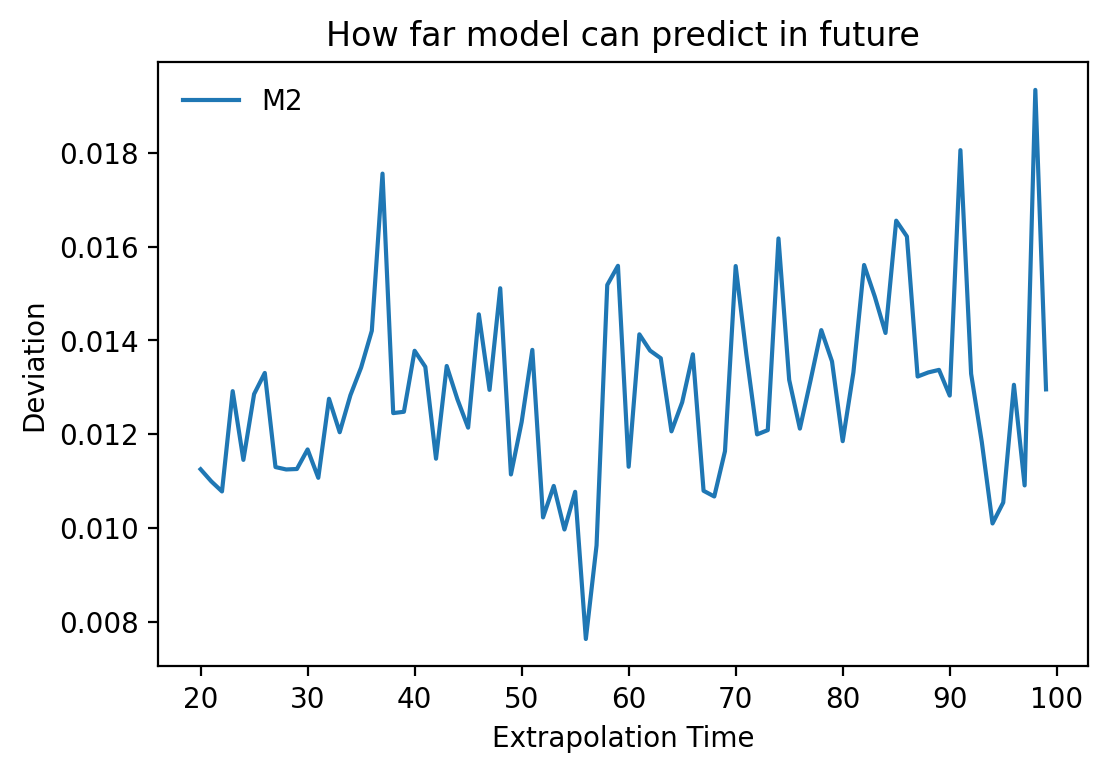

In [48]:

w = np.arange(len(m1_dev)) + 20
fig,ax=plt.subplots()
ax.plot(w, m2_dev, label='M2')
ax.set_xlabel("Extrapolation Time")
ax.set_ylabel("Deviation")
ax.set_title("How far model can predict in future")
ax.legend();

# Task 5.3
Despite some volatility, there is an upward trend in deviations with extrapolation time. The plot is quite volatile and with a large spike up in deviation around 35. This suggests that the predictive power of the model is only good up to 30 extrapolation time. This compares to up to 70 in Task 3. This again suggests that the model is compromised by the exclusion of m1's position.

# Task 5.4.1
Change to starting angles $\pi/2$

(4, 501)
Model: "sequential_412"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_412 (LSTM)             (None, 20)                1840      
                                                                 
 dense_412 (Dense)           (None, 2)                 42        
                                                                 
Total params: 1,882
Trainable params: 1,882
Non-trainable params: 0
_________________________________________________________________


100%|██████████| 481/481 [00:06<00:00, 72.87it/s]


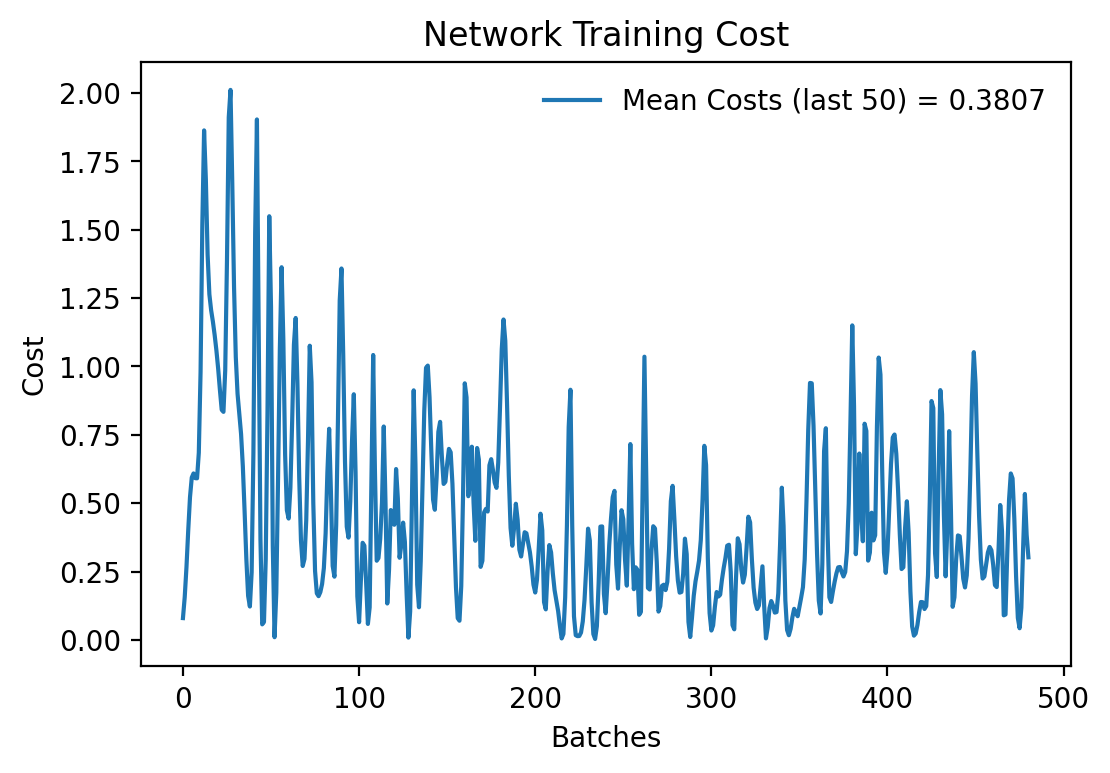

In [49]:
# Set up the initial conditions. Here we have lengths and masses
L1, L2 = 1., 1.
m1, m2 = 3., 1.
g = 9.81     # [m/s^2]. Gravitational acceleration

#Starting angles
z0=[np.pi/2,0,np.pi/2,0]# change starting angles
#z0=[0.1,0,0.1,0]

#Time ranges
tmax, dt = 50, 0.1
t = np.arange(0, tmax+dt, dt)

# Solve initial value problem
ret = solve_ivp(rhs, (0,tmax), z0, t_eval=t, args=(L1, L2, m1, m2, g))
z=ret.y
print(np.shape(z))

# Extract result
theta1, w1, theta2, w2 = z[0], z[1], z[2], z[3]
x1, y1, x2, y2, vx1, vy1, vx2, vy2 = to_cartesian(theta1, w1, theta2, w2, L1, L2)

# from https://numpy.org/doc/stable/reference/generated/numpy.stack.html#numpy.stack
pos = np.stack((x2,y2), axis=-1)#501 length array of x2, y2 values

#adapted from Week6_Prediction.ipynb
windowsize=20 #Number of samples we will use to train our network

#adapted from Week6_Prediction.ipynb
def shapeArray(x,windowsize):
    Input= np.array([x[i : i + windowsize] for i in range(len(x)-(windowsize))])
    Target= np.array([x[i+windowsize] for i in range(len(x)-(windowsize))])
    return (Input,Target)


#adapted from Week6_Prediction.ipynb
Input, Target = shapeArray(pos,windowsize)

#adapted from Week6_Prediction.ipynb
model=keras.models.Sequential()
model.add(keras.layers.LSTM(20,input_shape=(20, 2), return_sequences=False))#(20,2) represents the 20 wide window and 2 features
model.add(keras.layers.Dense(2,activation="linear"))# need 2 neurons to return the model values for x2, y2.
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

#adapted from Week6_Prediction.ipynb
batches=len(Input)#Number of batches
costs=np.zeros(batches)  #Array for plotting cost
for i in tqdm(range(batches)):
    In = Input[i].reshape(1,20, 2)#now only 2 features
    Tar = Target[i].reshape(1,1, 2)#now only 2 features
    costs[i]=model.train_on_batch(In, Tar) #Train the network

#Plot costs vs batches

fig,ax=plt.subplots()
ax.plot(np.arange(batches),costs,label=f"Mean Costs (last 50) = {np.mean(costs[-50:]):0.4f}")
ax.set_xlabel("Batches")
ax.set_ylabel("Cost")
ax.set_title("Network Training Cost")
ax.legend();



# Task 5.4.1
A poor cost function measure with little convergence shown. The mean cost (last 50) statistic acheived in Task 4.1 was 0.2421. Again the exclusion of x1,x2 has produced a less successful training.

# Task 5.4.2
Task 4.2 has already dealt with changing initial conditions, so it was decided to show the x2, y2 plots versus time for these starting angles.

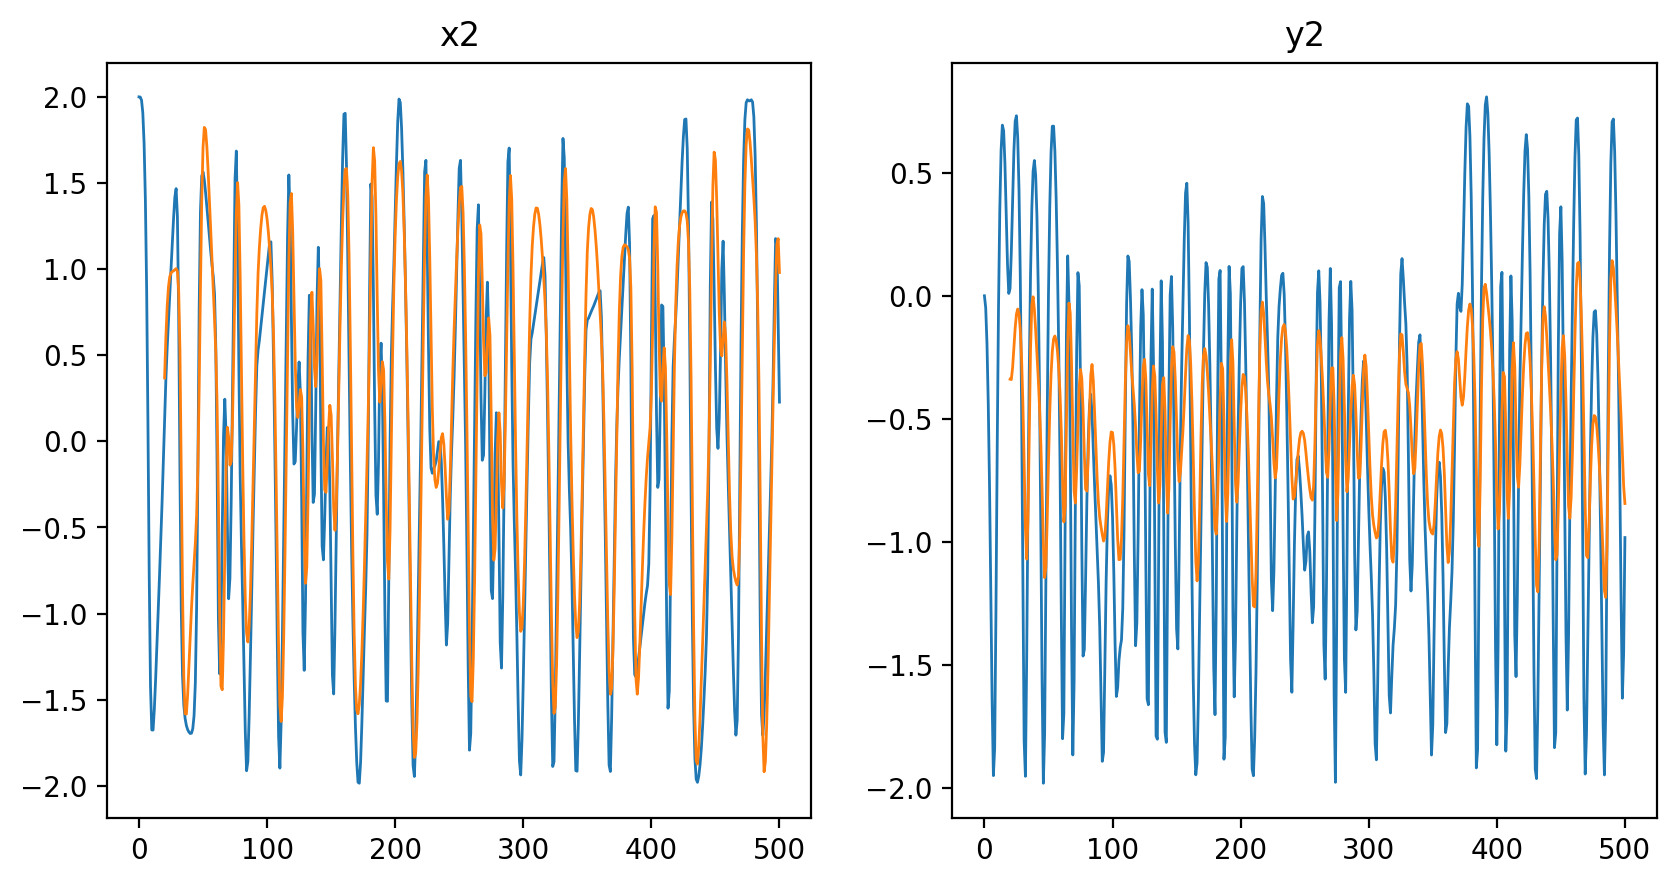

In [51]:
pred=np.zeros(len(Input)*2).reshape(len(Input),2)# only two features
for i in range(len(Input)):
  y_in = Input[i].reshape(1,20,2)
  y_out = model.predict_on_batch(y_in)
  pred[i] = y_out


t = np.arange(501)#all t values
t_p = np.arange(481) +20 #t values from t=20, i.e. for predicted values

fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(10,5))
ax[0].plot(t, pos[:,0], linewidth = 1)#from solv_ivp
ax[0].plot(t_p,pred[:,0], linewidth = 1)#from our model
ax[0].set_title('x2')

ax[1].plot(t, pos[:,1], linewidth = 1)
ax[1].plot(t_p,pred[:,1], linewidth = 1)
ax[1].set_title('y2');

# Task 5.4.2
As expected a complex solv_ivp plot and a model which struggles to follow it.

# Task 5.4.3 - last one!


In [52]:
# Set up the initial conditions. Here we have lengths and masses
L1, L2 = 1., 1.
m1, m2 = 3., 1.
g = 9.81     # [m/s^2]. Gravitational acceleration

#Starting angles
z0=[np.pi/2,0,np.pi/2,0]# change starting angles
#z0=[0.1,0,0.1,0]

#Time ranges
tmax, dt = 50, 0.1
t = np.arange(0, tmax+dt, dt)

# Solve initial value problem
ret = solve_ivp(rhs, (0,tmax), z0, t_eval=t, args=(L1, L2, m1, m2, g))
z=ret.y

# Extract result
theta1, w1, theta2, w2 = z[0], z[1], z[2], z[3]
x1, y1, x2, y2, vx1, vy1, vx2, vy2 = to_cartesian(theta1, w1, theta2, w2, L1, L2)

# from https://numpy.org/doc/stable/reference/generated/numpy.stack.html#numpy.stack
pos = np.stack((x2,y2), axis=-1)#501 length array of x2, y2 values
windowsize = 20
#adapted from Week6_Prediction.ipynb
def shapeArray(x,windowsize,offset):
    Input= np.array([x[i : i + windowsize] for i in range(len(x)-windowsize-offset)])
    Target= np.array([x[i+windowsize+offset] for i in range(len(x)-windowsize-offset)])
    return (Input,Target)

first_offset = 0
last_offset = 80

m2_dev = np.zeros(last_offset- first_offset)#array to capture deviations in m2
c=0# counter for index of m1_dev and m2_dev

#loop over different window sizes
for offset in range(first_offset,last_offset,1): 
  
  # produce Input and Target arrays for each windowsize
  Input, Target = shapeArray(pos,windowsize,offset)
  
  # model needs to be redefined and compiled for each windowsize
  model=keras.models.Sequential()
  model.add(keras.layers.LSTM(20,input_shape=(windowsize, 2), return_sequences=False))
  model.add(keras.layers.Dense(2,activation="linear"))# need 4 neurons to return the model values forx2, y2.
  model.compile(loss='mean_squared_error',optimizer='adam')

  #train the model for each windowsize
  batches=len(Input)#Number of batches
  costs=np.zeros(batches)  #Array for plotting cost
  for i in tqdm(range(batches)):
    In = Input[i].reshape(1,windowsize, 2)
    Tar = Target[i].reshape(1,1, 2)
    costs[i]=model.train_on_batch(In, Tar)

  # determine model predictions for each windowsize  
  pred=np.zeros(len(Input)*2).reshape(len(Input),2)# array to collect model predictions
  for i in range(len(Input)):
    y_in = Input[i].reshape(1,windowsize, 2)
    y_out = model.predict_on_batch(y_in)
    pred[i] = y_out
  
  # calculate deviations 
  m2_dev[c] = np.sum((pred[:,0] - pos[-len(pred):,0])**2 + (pred[:,1] - pos[-len(pred):,1])**2)**0.5/len(pred)
 

  #m2_dev[c] = ((np.sum(pred[:,2] - pos[-len(pred):,2])**2) + (np.sum(pred[:,3] - pos[-len(pred):,3])**2))**0.5/len(pred)
  c += 1



100%|██████████| 402/402 [00:05<00:00, 68.05it/s]


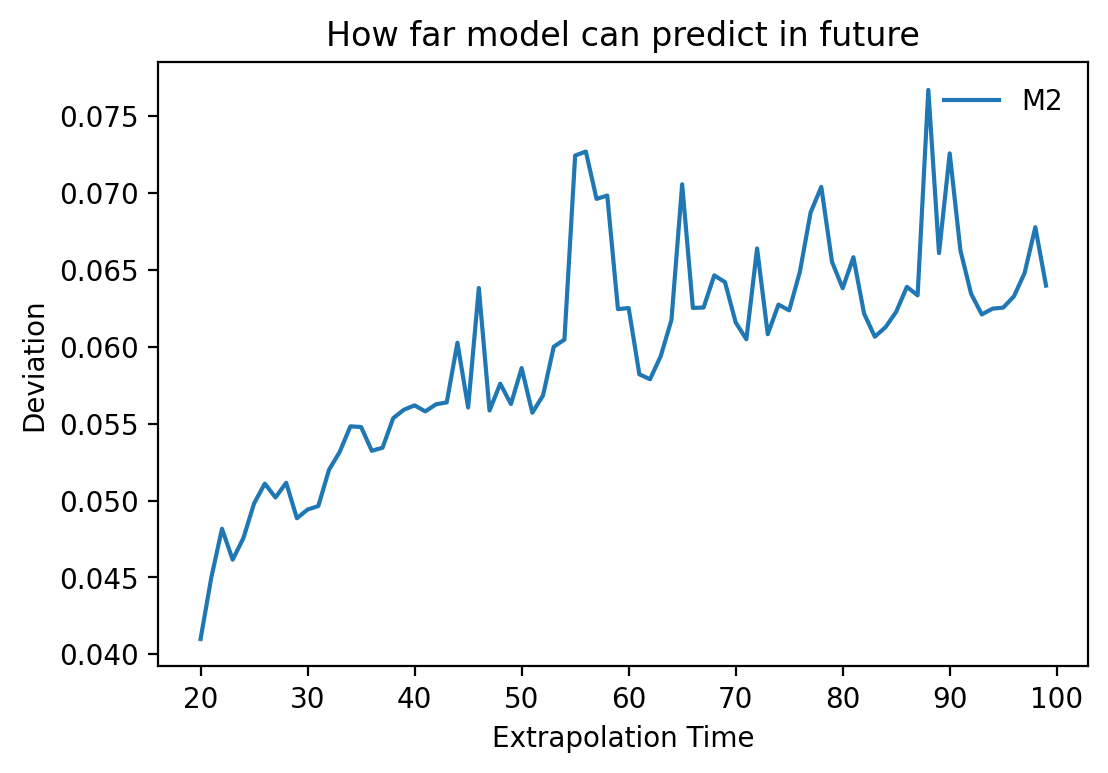

In [53]:

w = np.arange(len(m1_dev)) + 20
fig,ax=plt.subplots()
ax.plot(w, m2_dev, label='M2')
ax.set_xlabel("Extrapolation Time")
ax.set_ylabel("Deviation")
ax.set_title("How far model can predict in future")
ax.legend();

# Task 5.4.3.
In this situation, there is a clear upward trend in deviations with time. For this situaion you can't predict well into the future at all. This is not surprising as the angle is large, so the motion is complex and hard to model. In addition, we have not included m1 position co-ordinates, which as demonstrated already makes training harder.

# Key results
<p>Using m1 and m2 positions
<p>$\pi/4$ angles: cost = 0.0326, predicts forward: 70 intervals
<p>$\pi/2$ angles: cost = 0.2421, predicts forward: 30 intervals
<p>
<p>Using just m2 positions
<p>$\pi/4$ angles: cost = 0.0586, predicts forward: 30 intervals
<p>$\pi/2$ angles: cost = 0.3807, predicts forward: 0 intervals



# Overall conclusions
LSTM models using just position co-ordinates model double pendulum motion well for small angles (e.g. $\pi/4$) but poorly for large angles (e.g. $\pi/2$ or above). This can be quantified by the cost function and the ability of the model to predict forward by extrapolation by considering position deviations. The models adjust appropriately to changes in the initial conditions, but large angles cause a more complex motion which is far harder to model.

<p>Far better training comes by including both m1 and m2 in the training. This is not surprising given the pull of one on the other in the double pendulum set up.